### Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive_dir = '/content/drive/MyDrive/AIF/'
file_path = 'Dataset_2.0_Akkodis_final.xlsx'

### Install requirements

In [3]:
source_path = drive_dir + 'requirements.txt'
!pip install -r {source_path}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 5

### Imports

In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from lime import lime_tabular
import shap
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV, StratifiedKFold
import sklearn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import time
import pickle

random_seed = 42
random_state = 42

###Utils

#####Visualization

In [5]:
def getPie(df, feature, mapping):
  distribution = df[feature].value_counts(normalize=True)
  plt.figure(figsize=(8, 6))
  labels = [mapping[feature][i] for i in distribution.index]
  plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 8})
  plt.rcParams.update({'font.size': 10})
  plt.title(f'Distribution of {feature}')
  plt.show()

In [6]:
def plot_category_distributions(df, group_col, target_col, encoding_mappings, reverse_mapping):
    group_values = encoding_mappings[group_col]

    distribs = {}
    for group_key, encoded_value in group_values.items():
        distrib = df[df[group_col] == encoded_value][target_col].value_counts(normalize=True)
        if not distrib.empty:
            distribs[group_key] = distrib

    num_subplots = len(distribs)
    rows = num_subplots // 3 + (num_subplots % 3 > 0)
    cols = min(num_subplots, 3)
    plt.figure(figsize=(num_subplots * 5, num_subplots * 5))
    plt.rcParams.update({'font.size': 4*num_subplots})
    for i, (group_label, distribution) in enumerate(distribs.items()):
        plt.subplot(rows, cols, i + 1)

        labels = [reverse_mapping[target_col][idx] for idx in distribution.index]

        plt.pie(distribution, labels=labels, autopct='%1.1f%%', startangle=90)
        plt.title(f'{target_col} distrib for {group_label} as {group_col.replace("_encoded", "")}')

    plt.tight_layout()
    plt.show()


In [7]:
def plot_bar_norm(data_set, feature, target, encoding_mappings, reverse_mapping):
    plt.rcParams.update({'font.size': 10})
    pivot = data_set.pivot_table(index=feature, columns=target, aggfunc='size', fill_value=0)
    pivot.rename(columns=reverse_mapping[target], inplace=True)
    pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

    ax = pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

    if feature in encoding_mappings.keys():
        ax.set_xticklabels(encoding_mappings[feature].keys())

    plt.title(f'{target} by {feature} (Normalized)')
    plt.ylabel('Proportion')
    plt.xlabel(feature)
    plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


#####shap explanations

In [8]:
#FOR SHAP EXPLANATIONS
def create_explanations(model, X, name):
    if name.startswith('Neural Network'):
        explainer = shap.GradientExplainer ( model, X_test.values)
        shap_values = explainer.shap_values(X_test.values)[:1000].squeeze()
        print("shap shape:", shap_values.shape)
        return shap_values, X

    explainer = shap.Explainer(model, X)
    explanations = explainer(X)
    return explanations, X

def summaryPlot(model, X, lf, plot_type, plot_name):
    explanations, X = create_explanations(model, X, plot_name)

    fig, ax = plt.subplots()
    plt.title(f"{plot_name}")
    shap.summary_plot(explanations, X, lf, show=False, plot_size=None, plot_type=plot_type, max_display=len(lf), sort=True)
    plt.tight_layout()
    plt.show()
    plt.close()

#####training

In [9]:
def reweight_dataset(X_train, y_train, sensitive_features, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    group_counts = X_train.groupby(sensitive_features).size()
    group_weights = 1 / group_counts
    group_weights /= group_weights.sum()

    sample_weights = X_train[sensitive_features].apply(tuple, axis=1).map(group_weights)

    sample_weights /= sample_weights.sum()

    reweighted_indices = np.random.choice(
        X_train.index,
        size=len(X_train),
        replace=True,
        p=sample_weights)
    X_train_reweighted = X_train.loc[reweighted_indices]
    y_train_reweighted = y_train.loc[reweighted_indices]

    return X_train_reweighted, y_train_reweighted


In [10]:
def fit_predict_model(name, model, X_train, y_train, X_test, y_test, metrics, predictions):
    print(f"Fitting {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred

    if name in ['Linear Regression', 'XGBoost']:
        y_pred = (y_proba > 0.5).astype(int)

    predictions[name] = y_pred

    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
    recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
    f1 = round(f1_score(y_test, y_pred), 3)
    roc_auc = round(roc_auc_score(y_test, y_proba), 3)

    if sum(y_pred) == 0:
        print(f"Warning: No positive predictions for {name}. Precision and Recall may be ill-defined.")

    metrics.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

In [11]:
def create_model(neurons = 128, optimizer = 'adam', activation = 'relu') :
    model = Sequential()
    model.add(Input(shape=(len(X.columns),)))
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(neurons, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(neurons // 2, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer= optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
def fit_nn(name, seed, neural_models, histories, X_train, y_train, X_test, neural_predictions, best_params, early_stopping=None):
    print(f"Fitting model {name}...")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model = create_model(neurons = best_params['neurons'], optimizer = best_params['optimizer'], activation = best_params['activation'] )
    neural_models.append(model)
    if early_stopping is not None:
        history = model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.2,
        callbacks= [early_stopping])
    else:
      history = model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.2)
    histories.append(history)
    print(f"Model {name} fitted.\n")


In [13]:
def predict_nn(name, model, X_test, neural_predictions):
    print(f"Predicting with model {name}...")
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    neural_predictions.append(y_pred)
    print(f"Predictions from model {name} stored.\n\n")

In [14]:
def plot_val_train(h, name):
  plt.plot(h.history['accuracy'])
  plt.plot(h.history['val_accuracy'])
  plt.title(f'{name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title(f'{name} Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [15]:
def calc_nn_metrics(y_pred, y_test, nn_metrics, name):
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred, zero_division=0), 3)
  recall = round(recall_score(y_test, y_pred, zero_division=0), 3)
  f1 = round(f1_score(y_test, y_pred), 3)
  roc_auc = round(roc_auc_score(y_test, y_pred), 3)

  nn_metrics.append({
      'Model': name,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1 Score': f1,
      'ROC AUC': roc_auc
  })

#####fairness metrics

In [62]:
def calculate_demographic_parity(predictions, y_test, name, significance_level, tolerance, X_test, activate_check=False, model = None):

    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': X_test[name]
    })
    # Proportion of positive predictions for each group
    positive_proportions = df.groupby('sensitive_attribute')['predictions'].mean()
    num_class = positive_proportions.shape[0]
    min_proportion = positive_proportions.min()
    max_proportion = positive_proportions.max()
    percentage_difference = (max_proportion - min_proportion)
    discr_gr = reverse_mapping[name][positive_proportions.index[positive_proportions.values.argmin()]]
    # Case for binary sensitive attribute
    if num_class == 2:

        if activate_check == True and percentage_difference > tolerance:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            print(f"{reverse_mapping[name][0]}: {positive_proportions[0]}")
            print(f"{reverse_mapping[name][1]}: {positive_proportions[1]}")
            print(f"Model unfair to: {discr_gr}")
            print("=====================================================================\n\n")
        if percentage_difference <= tolerance:
            return True
        else:
            return discr_gr

    # Case for multiclass sensitive attribute
    if num_class > 2:
        contingency_table = pd.crosstab(df['predictions'], df['sensitive_attribute'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        if activate_check == True and p <= significance_level:
            print("===============================UNFAIR!===============================")
            print(f"Model {model} unfair wrt {name}")
            if (expected < 5).any():
                print(f"Sparse contigency for {name}")
            else:
              for i in range(len(positive_proportions)):
                print(f"{reverse_mapping[name][i]}: {positive_proportions[i]}")
              print(f"Model unfair to: {discr_gr}")

            print("=====================================================================\n\n")
        if p > significance_level:
            return True
        else:
            return discr_gr

In [63]:
def calculate_equalized_odds(predictions, true_labels, name, significance_level, tolerance, X_test, activate_check=False, model = None):
    df = pd.DataFrame({
        'predictions': predictions,
        'true_labels': true_labels,
        'sensitive_attribute': X_test[name]
    })

    # Calculate TPR and FPR for each group
    groups = df['sensitive_attribute'].unique()
    metrics = {}
    for group in groups:
        group_df = df[df['sensitive_attribute'] == group]
        cm = confusion_matrix(group_df['true_labels'], group_df['predictions'], labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        if tp + fn == 0:
            print(f"\n\nThere are no positive examples for the group {reverse_mapping[name.replace('_encoded', '')][group]} in the test set")
        if fp + tn == 0:
            print(f"\n\nThere are no negative examples for the group{reverse_mapping[name.replace('_encoded', '')][group]} in the test set")
        tpr = tp / (tp + fn) if tp + fn != 0 else 0
        fpr = fp / (fp + tn) if fp + tn != 0 else 0
        metrics[group] = {'TPR': tpr, 'FPR': fpr}

    # Check if TPR and FPR are within the tolerance
    tprs = [metrics[group]['TPR'] for group in groups]
    fprs = [metrics[group]['FPR'] for group in groups]

    max_tpr_diff = max(tprs) - min(tprs)
    max_fpr_diff = max(fprs) - min(fprs)

    tpr_within_tolerance = max_tpr_diff <= tolerance*2
    fpr_within_tolerance = max_fpr_diff <= tolerance*2
    result = tpr_within_tolerance and fpr_within_tolerance
    discr_gr_tpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['TPR'])]
    discr_gr_fpr = reverse_mapping[name][min(metrics, key=lambda g: metrics[g]['FPR'])]
    if activate_check == True and result == False:
        max_tpr_group = max(metrics, key=lambda g: metrics[g]['TPR'])
        min_tpr_group = min(metrics, key=lambda g: metrics[g]['TPR'])
        max_fpr_group = max(metrics, key=lambda g: metrics[g]['FPR'])
        min_fpr_group = min(metrics, key=lambda g: metrics[g]['FPR'])
        print("===============================UNFAIR!===============================")
        print(f"Model {model} unfair wrt {name}")
        if tpr_within_tolerance == False:
            print(f"Maximum TPR difference: {max_tpr_diff:.4f} between group {reverse_mapping[name][max_tpr_group]} and group {reverse_mapping[name][min_tpr_group]}")
            print(f"Model unfair to: {discr_gr_tpr}")
        if fpr_within_tolerance == False:
            print(f"Maximum FPR difference: {max_fpr_diff:.4f} between group {reverse_mapping[name][max_fpr_group]} and group {reverse_mapping[name][min_fpr_group]}")
            print(f"Model unfair to: {discr_gr_fpr}")
        print("TPR and FPR for each group:")
        for group, metric in metrics.items():
            print(f"Group {reverse_mapping[name][group]}: TPR={metric['TPR']:.4f}, FPR={metric['FPR']:.4f}")
        print("=====================================================================\n\n")
    if result == False:
      if tpr_within_tolerance == False and fpr_within_tolerance == False:
        if discr_gr_fpr == discr_gr_tpr:
          return discr_gr_fpr
        else:
          return discr_gr_tpr+' '+discr_gr_fpr
      elif tpr_within_tolerance == False:
        return discr_gr_tpr
      else:
        return discr_gr_fpr
    else:
      return True

In [147]:
def calculate_counterfactual_fairness(predictions, y_test, name, significance_level, tolerance, X_test, model=None, activate_check=False):
    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': X_test[name]
    })

    counterfactual_df = X_test.copy()
    delta = {}
    accuracy = {}

    for group in df['sensitive_attribute'].unique():
        counterfactual_df[name] = group

        if isinstance(model, tf.keras.Sequential) or isinstance(model, tf.keras.Model):
            new_preds = model.predict(counterfactual_df, verbose=0)
        else:
            new_preds = model.predict(counterfactual_df)
        if len(np.unique(new_preds)) > 2:
            new_preds = (new_preds > 0.5).astype(int)

        accuracy[group] = accuracy_score(predictions, new_preds)

        n_old = np.sum(predictions)
        n_new = np.sum(new_preds)
        delta[group] = round((n_new - n_old) /len(predictions), 4)


    most_inaccurate_group = min(accuracy, key=accuracy.get)
    counterfactual_consistency = accuracy[most_inaccurate_group]

    most_discriminated_group = min(delta, key=delta.get)
    delta_min = delta[most_discriminated_group]
    most_privileged_group = max(delta, key=delta.get)
    delta_max = delta[most_privileged_group]
    #is_fair = (delta_max - delta_min < tolerance) or (counterfactual_consistency >= (1 - tolerance))
    is_fair = counterfactual_consistency >= (1 - tolerance)

    if activate_check:
      if not is_fair:
        print("===============================UNFAIR!===============================")
      else:
        print("=====================================================================")
      print(f"Model {model} unfair wrt Counterfactual Fairness on {name}")
      print(f"Counterfactual consistency: {counterfactual_consistency:.4f}")
      print(f"Most inaccurate group: {reverse_mapping[name][most_inaccurate_group]} {delta[most_inaccurate_group]:.4f}")
      print(f"Most discriminated group: {reverse_mapping[name][most_discriminated_group]} {delta_min:.4f}")
      print(f"Most privileged group: {reverse_mapping[name][most_privileged_group]} {delta_max:.4f}")
      print(f"Direction of bias (negative = worse, positive = better)")
      print("=====================================================================\n\n")

    if not is_fair:
        return reverse_mapping[name][most_discriminated_group], delta_min, reverse_mapping[name][most_privileged_group], delta_max

    return True


In [142]:
def getFairnessTab(fn, models, sensitive_features, predictions, index, X_test, significance_level, tolerance, verbose=False):
    table = []

    for model_name in index:
        temp = []
        for i in range(len(sensitive_features)):
            model_predictions = predictions[model_name]
            output = fn(
                model_predictions,
                y_test,
                sensitive_features[i],
                significance_level,
                tolerance,
                X_test,
                model=models[model_name],
                activate_check=verbose
            )

            if output == True:
                temp.append('')
            else:
                temp.append(output)
        table.append(temp)

    return pd.DataFrame(table, index=index, columns=sensitive_features)


In [19]:
def calculate_conditional_statistical_parity(predictions, y_test, name, significance_level, tolerance, conditioning_variable=['Study Title_encoded'], X_test=None, activate_check=False, model=None):

    if isinstance(conditioning_variable, str):
        conditioning_variable = [conditioning_variable]

    df = pd.DataFrame({
        'predictions': predictions,
        'sensitive_attribute': X_test[name]
    })

    for var in conditioning_variable:
        df[var] = X_test[var]

    disparity = {}
    mean_predictions = {}

    for group in df['sensitive_attribute'].unique():
        group_df = df[df['sensitive_attribute'] == group]

        conditioned_probs = group_df.groupby(conditioning_variable)['predictions'].mean()
        disparity[group] = (conditioned_probs.max() - conditioned_probs.min())
        mean_predictions[group] = group_df['predictions'].mean()

    most_discriminated_group = max(disparity, key=disparity.get)
    max_disparity_value = disparity[most_discriminated_group]

    worst_group = min(
        [g for g in disparity if disparity[g] == max_disparity_value],
        key=lambda g: mean_predictions[g]
    )

    is_fair = max_disparity_value <= tolerance

    if activate_check and not is_fair:
        print("=============================== UNFAIR! ===============================")
        print(f"Model {model} unfair wrt Conditional Statistical Parity on {name} given {conditioning_variable}")
        print(f"Maximum conditional disparity: {max_disparity_value:.4f}")
        print(f"Most discriminated group (more negative predictions): {reverse_mapping[name][worst_group]}")
        print("========================================================================\n\n")

    return True if is_fair else reverse_mapping[name][worst_group]


###Classes

In [21]:
class CustomKerasClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    def __init__(self, input_shape, neurons=10, activation='relu', optimizer='adam', batch_size=32, epochs=20):
        self.input_shape = input_shape
        self.neurons = neurons
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs

    def build_tf_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Dense(self.neurons, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(self.neurons, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(self.neurons, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(self.neurons // 2, activation=self.activation))
        model.add(BatchNormalization())
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer=self.optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        return model

    def fit(self, X, y):
        self.model = self.build_tf_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self

    def predict(self, X):
        y_pred_proba = self.model.predict(X)
        return (y_pred_proba > 0.5).astype(int).flatten()


## Dataset Import

In [24]:
df = pd.read_excel(drive_dir + file_path)

print(f"There are {df['Id'].unique().shape[0]} candidates\n")

print(f"Total number of rows: {df.shape[0]}\n")

print(f"HIRED distribution: \n\n{df['Hired'].value_counts()}\n\n")

df.head()

There are 4705 candidates

Total number of rows: 14115

HIRED distribution: 

Hired
0    13685
1      430
Name: count, dtype: int64




Id Candidate State      Age Range     Sex Protected Category  \
0   165           hired  26 - 30 years    male                 no   
1   369           hired  26 - 30 years  female                 no   
2   423           hired  36 - 40 years    male                 no   
3  1006           hired     > 45 years    male                 no   
4  1038           hired  26 - 30 years    male                 no   

                                                 Tag              Study Area  \
0                               angular, javascript.             informatics   
1                                             matlab  mechanical engineering   
2  blood lines, medical device, medical devices d...             informatics   
3                                      not specified                   other   
4                                      not specified             informatics   

              Study Title Years Experience         Sector  ...  \
0       three-year degree            [1-3]        telecom  ...   
1       three-year degree            [1-3]     automotive  ...   
2  high school graduation            [+10]  life sciences  ...   
3  high school graduation            [+10]         energy  ...   
4  high school graduation            [1-3]     consulting  ...   

  Residence_coord  Assumption_coord Distance (km)  \
0    (None, None)      (None, None)           0.0   
1    (None, None)      (None, None)           0.0   
2    (None, None)      (None, None)           0.0   
3    (None, None)      (None, None)           0.0   
4    (None, None)      (None, None)           0.0   

                                       Position_Info Similarity_Score  \
0  frontend developer tech consulting solutions c...             0.17   
1  powertrain calibration engineer engineering ju...             0.14   
2                             engineering consultant             0.00   
3  rs190865 team procurement milan engineering 1 ...             0.36   
4  hardware, software, networking mostggs support...             0.00   

  Similarity_Score_Study_Area Study_Title_Score Similarity_Score_Last_Role  \
0                        1.00              0.00                        0.0   
1                        0.19             -0.14                        0.0   
2                        0.00              0.00                        0.0   
3                        0.00             -0.14                        0.0   
4                        0.00             -0.29                        0.0   

  Years_Exp_Score Ral_Score  
0            0.00     -0.07  
1            0.07      0.00  
2            0.00      0.00  
3            1.00      0.00  
4           -0.10      0.00  

[5 rows x 51 columns]

In [25]:
#new sensitive column
df['Italian'] = df['Residence Country'].apply(lambda x: 'yes' if x == 'italy' else 'no')


##Data Set
Some columns will be dropped either because they would not be available (i.e. Candidate State) or because of redundancy.

In [26]:
data_set = df.copy()

columns_to_drop = ['Candidate State', 'Tag' , 'Recruitment Request', 'Last Role',
                   'Job Description', 'Candidate Profile', 'Year Of Insertion', 'Year Of Recruitment',
                   'Job Title Hiring', 'Years Experience.1', 'Study Level', 'Study Area.1',
                   'Job ID', 'Residence_coord', 'Assumption_coord', 'Assumption Headquarters',
                   'Candidate_Info', 'Position_Info', 'Akkodis Headquarters', 'Job Family Hiring']

data_set = data_set.drop(columns=columns_to_drop)

for col in data_set.columns:
  print(f"{col}: \n {data_set[col].unique()}")

Id: 
 [  165   369   423 ... 81623 81627 81630]
Age Range: 
 ['26 - 30 years' '36 - 40 years' '> 45 years' '31 - 35 years' '< 20 years'
 '40 - 45 years' '20 - 25 years']
Sex: 
 ['male' 'female']
Protected Category: 
 ['no' 'yes']
Study Area: 
 ['informatics' 'mechanical engineering' 'other' 'biomedical engineering'
 'aeronautical/aerospace/astronautics engineering'
 'other scientific subjects' 'political-social' 'electronic engineering'
 'electrical engineering' 'computer engineering'
 'telecommunications engineering' 'automotive engineering' 'surveyor'
 'automation/mechatronics engineering' 'economic - statistics'
 'other humanities subjects' 'energy and nuclear engineering' 'psychology'
 'chemical engineering' 'information engineering' 'management engineering'
 'chemist - pharmaceutical' 'accounting' 'industrial engineering'
 'communication sciences' 'mathematics' 'literary'
 'civil/civil and environmental engineering'
 'humanistic high school diploma' 'linguistics'
 'agriculture and

##Preprocessing
### Categorical - Numerical mapping

In [27]:
ral_mapping = {
     '-20k': 10,
     '20-22k': 21,
     '22-24k': 23,
     '24-26k': 25,
     '26-28k': 27,
     '28-30k': 29,
     '30-32k': 31,
     '32-34k': 33,
     '34-36k': 35,
     '36-38k': 37,
     '38-40k': 39,
     '40-42k': 41,
     '42-44k': 43,
     '44-46k': 45,
     '46-48k': 47,
     '48-50k': 49,
     '+50k': 70,
     'not specified': 'not specified'
}

for col in data_set.columns:
  if 'Ral' in col and col != 'Ral_Score':
     data_set[col] = data_set[col].map(ral_mapping)

years_exp_mapping = {
    '[0]': 0,
    '[0-1]': 0.5,
    '[1-3]': 2,
    '[3-5]': 4,
    '[5-7]': 6,
    '[7-10]': 8.5,
    '[+10]': 20
}

data_set['Years Experience'] = data_set['Years Experience'].map(years_exp_mapping)

### Encoding of categorical columns

In [28]:
categorical_columns = ['Sex', 'Age Range', 'Protected Category', 'Study Area', 'Study Title',
                       'Sector', 'Residence Country', 'Residence Italian Region',
                       'European Residence', 'Italian']
numerical_columns = [col for col in data_set.columns if col not in categorical_columns]

In [29]:
encoding_mappings = {}

encoding_mappings['Age Range_encoded'] = {
    '< 20 years': 0,
    '20 - 25 years': 1,
    '26 - 30 years': 2,
    '31 - 35 years': 3,
    '36 - 40 years': 4,
    '40 - 45 years': 5,
    '> 45 years': 6
}

data_set['Age Range_encoded'] = data_set['Age Range'].map(encoding_mappings['Age Range_encoded'])
data_set = data_set.drop(columns='Age Range')

categorical_columns.remove('Age Range')

encoding_mappings['Study Title_encoded'] = {
    'middle school diploma': 0,
    'professional qualification': 1,
    'high school graduation': 2,
    'three-year degree': 3,
    'five-year degree': 4,
    'master\'s degree': 5,
    'doctorate': 6
}

data_set['Study Title_encoded'] = data_set['Study Title'].map(encoding_mappings['Study Title_encoded'])
data_set = data_set.drop(columns='Study Title')

categorical_columns.remove('Study Title')

for col in categorical_columns:
  label_encoder = LabelEncoder()
  data_set[f"{col}_encoded"] = label_encoder.fit_transform(data_set[col])
  encoding_mappings[f"{col}_encoded"] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

data_set = data_set.drop(columns=categorical_columns)

encoding_mappings['Hired'] = {'Not Hired': 0, 'Hired': 1}

reverse_mapping = {}

for col, mapping in encoding_mappings.items():
    reverse_mapping[col] = {v: k for k, v in mapping.items()}

###NaN handling

'not specified' values for numerical columns are replaced with the mean value.

In [30]:
not_spec_col = []

for col in data_set.columns:
  if 'not specified' in data_set[col].unique() :
    not_spec_col.append(col)

for col in not_spec_col:
  if col in numerical_columns:
    data_set[col] = pd.to_numeric(data_set[col], errors='coerce')
    mean_val = data_set[col].dropna().mean()
    if pd.isna(mean_val):
      mean_val = 0
    else:
      mean_val = round(mean_val)

    data_set[col] = data_set[col].replace('not specified', mean_val)
    data_set[col] = data_set[col].fillna(mean_val)

for col in not_spec_col:
  print(type(data_set[col][0]))
  print(f"{col}: {data_set[col].unique()}")

<class 'numpy.float64'>
Overall: [3. 2. 4. 1.]
<class 'numpy.float64'>
Minimum Ral: [23. 29. 25. 21. 31. 27. 10. 33. 39. 37. 41. 35. 70.]
<class 'numpy.float64'>
Ral Maximum: [29. 25. 26. 33. 31. 37. 35. 49. 27. 41. 45. 39. 10. 43. 70. 23. 21.]
<class 'numpy.float64'>
Current Ral: [23. 34. 35. 27. 29. 21. 70. 31. 39. 33. 43. 37. 25. 10. 41. 45. 49. 47.]
<class 'numpy.float64'>
Expected Ral: [27. 37. 41. 33. 31. 25. 70. 29. 39. 35. 43. 10. 21. 23. 45. 47. 49.]
<class 'numpy.float64'>
Technical Skills: [2. 3. 1. 4.]
<class 'numpy.float64'>
Standing/Position: [3. 2. 4. 1.]
<class 'numpy.float64'>
Communication: [3. 2. 4. 1.]
<class 'numpy.float64'>
Maturity: [3. 2. 4. 1.]
<class 'numpy.float64'>
Dynamism: [3. 2. 4. 1.]
<class 'numpy.float64'>
Mobility: [1. 2. 3. 4.]
<class 'numpy.float64'>
English: [3. 2. 4. 1.]


### Standardization

In [ ]:
for col in numerical_columns:
  print(f"{col}: {np.sort(data_set[col].unique().tolist())}")

Id: [   41    47    84 ... 81623 81627 81630]
Years Experience: [ 0.   0.5  2.   4.   6.   8.5 20. ]
Overall: [1. 2. 3. 4.]
Minimum Ral: [10. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 70.]
Ral Maximum: [10. 21. 23. 25. 26. 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 49. 70.]
Current Ral: [10. 21. 23. 25. 27. 29. 31. 33. 34. 35. 37. 39. 41. 43. 45. 47. 49. 70.]
Expected Ral: [10. 21. 23. 25. 27. 29. 31. 33. 35. 37. 39. 41. 43. 45. 47. 49. 70.]
Technical Skills: [1. 2. 3. 4.]
Standing/Position: [1. 2. 3. 4.]
Communication: [1. 2. 3. 4.]
Maturity: [1. 2. 3. 4.]
Dynamism: [1. 2. 3. 4.]
Mobility: [1. 2. 3. 4.]
English: [1. 2. 3. 4.]
Hired: [0 1]
Distance (km): [    0.          1390.50441853  3107.25044461  3450.58837138
  3597.21815268  3881.23319194  4248.00957535  4436.45261915
  4442.64245181  4497.09194585  4865.65750542  4901.84372658
  5022.23190076  5125.97476816  5215.98210688  5248.72721712
  5295.78515257  5356.79099448  5450.60842217  5590.57162506
  5612.96245939  5714.43783331  5

###Std Scaler export

In [31]:
columns_to_standardize = ['Years Experience', 'Minimum Ral', 'Ral Maximum', 'Current Ral',
                          'Expected Ral', 'Distance (km)']

scaler = StandardScaler()

for col in columns_to_standardize:
  data_set[f"{col}_not_std"] = data_set[col]

data_set[columns_to_standardize] = scaler.fit_transform(data_set[columns_to_standardize])

std_mappings = {}
for col in columns_to_standardize:
    std_mappings[col] = {
        row[f"{col}_not_std"]: round(row[col], 2) for _, row in data_set.iterrows()
    }

for col in columns_to_standardize:
  data_set = data_set.drop(columns=f"{col}_not_std")

data_set[columns_to_standardize] = round(data_set[columns_to_standardize], 2)

reverse_std_mappings = {}

for col, mapping in std_mappings.items():
    reverse_std_mappings[col] = {v: k for k, v in mapping.items()}

## Correlation matrix

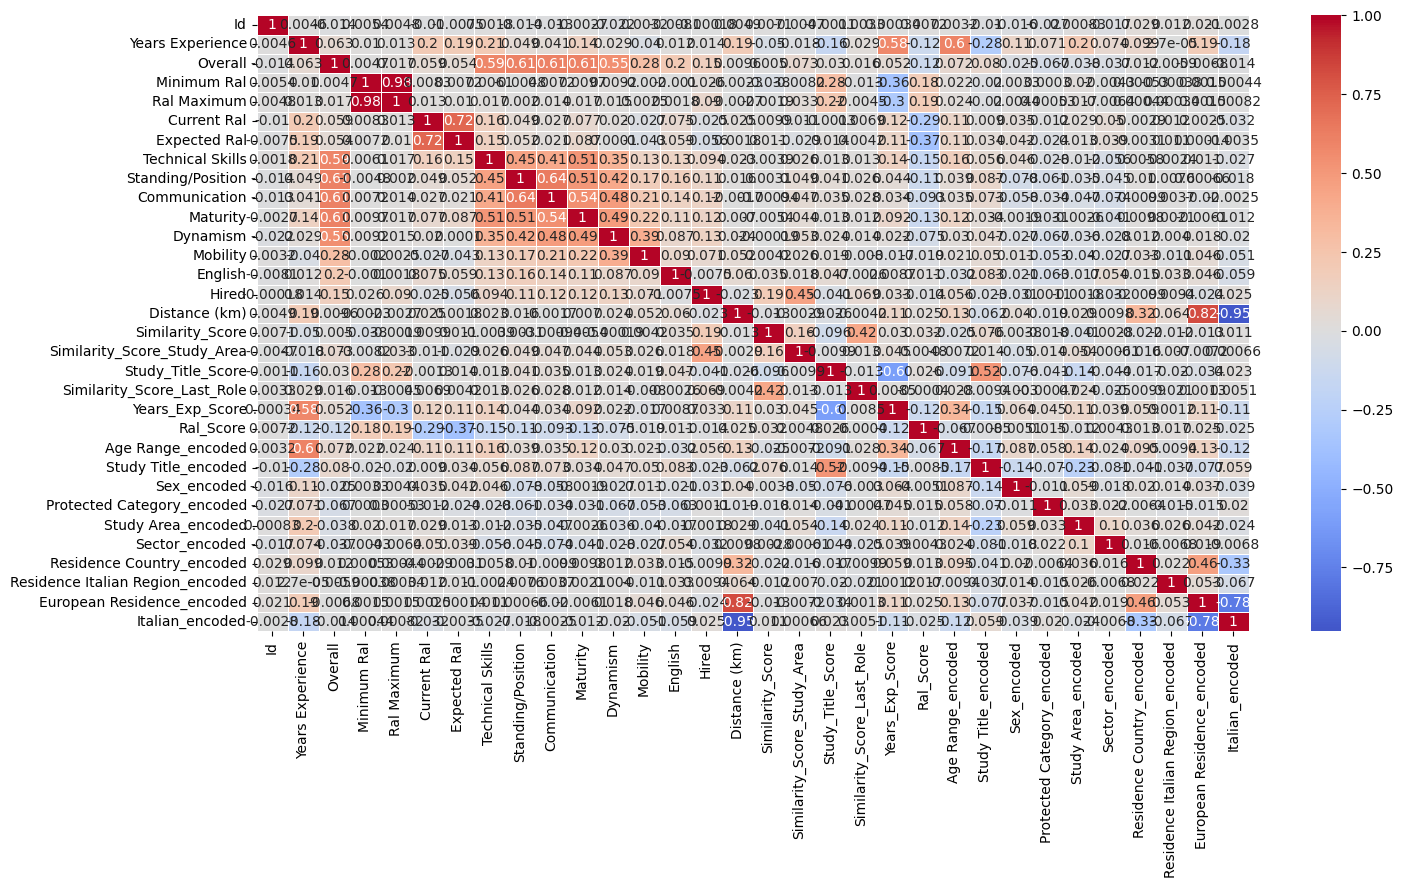

In [32]:
# Correlation matrix
corr_matrix = data_set.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.show()

##Data Analysis

###Custom orders

###Hired

In [ ]:
data_set['Hired'].value_counts()

Hired
0    13685
1      430
Name: count, dtype: int64

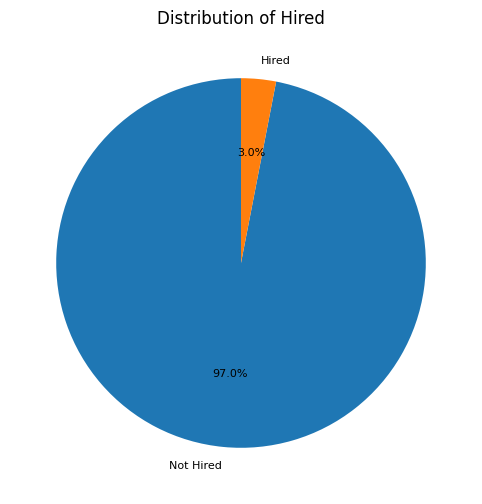

In [ ]:
getPie(data_set, 'Hired', reverse_mapping)

###Sex

In [ ]:
data_set['Sex_encoded'].value_counts()

Sex_encoded
1    11355
0     2760
Name: count, dtype: int64

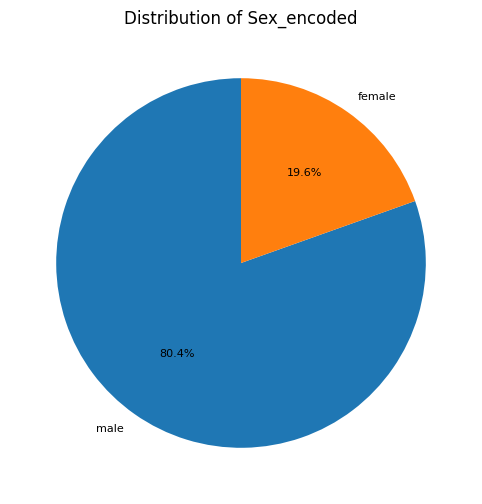

In [ ]:
getPie(data_set, 'Sex_encoded', reverse_mapping)

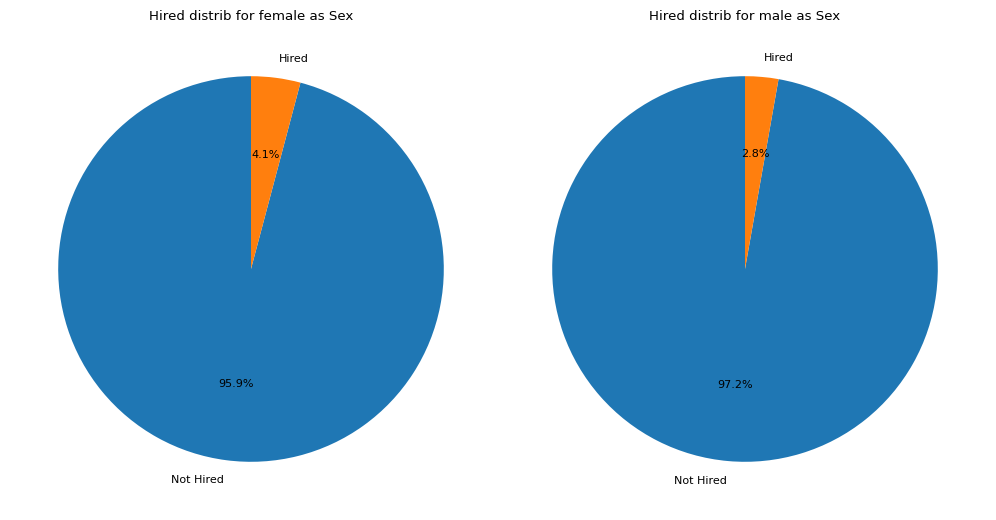

In [ ]:
plot_category_distributions(data_set, 'Sex_encoded', 'Hired', encoding_mappings, reverse_mapping)

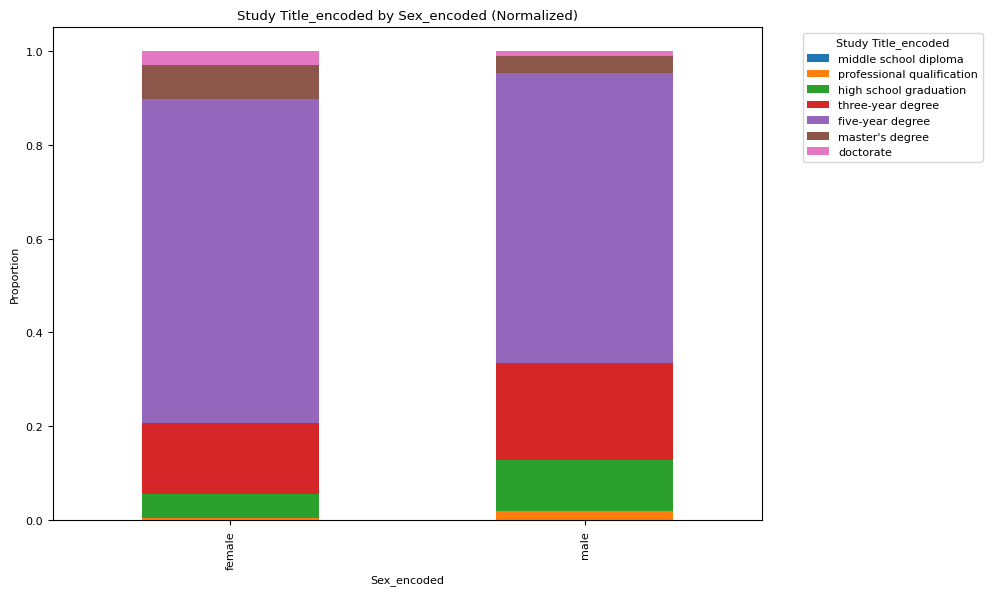

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

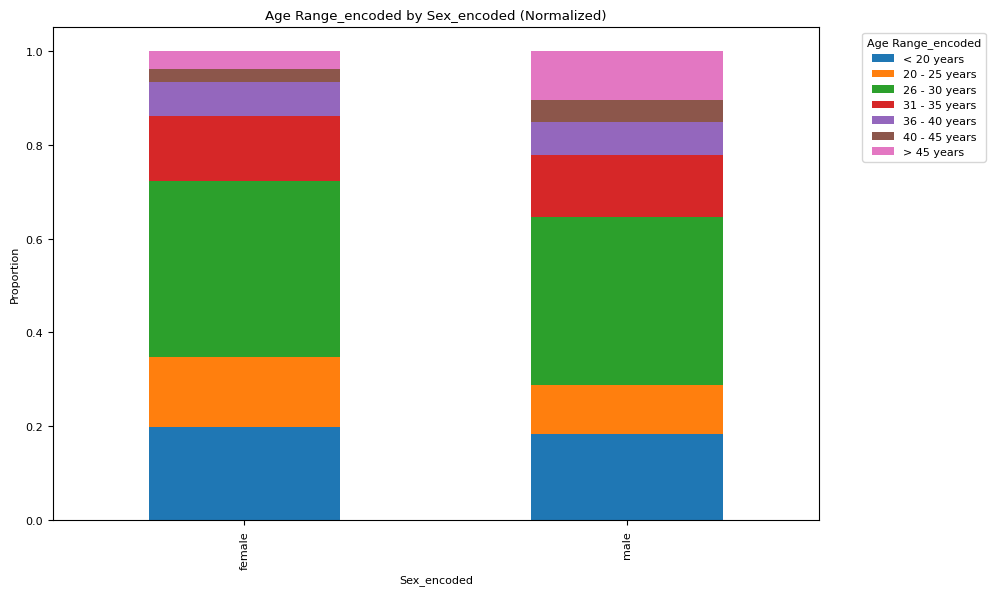

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Age Range_encoded', encoding_mappings, reverse_mapping)

In [ ]:
years_exp_rev_mapping = {
    v: k for k, v in years_exp_mapping.items()
}

In [ ]:
for k, v in reverse_std_mappings['Years Experience'].items():
  reverse_std_mappings['Years Experience'][k] = years_exp_rev_mapping[v]

In [ ]:
reverse_std_mappings['Sex_encoded'] = {}
reverse_std_mappings['Sex_encoded'][0] = 'female'
reverse_std_mappings['Sex_encoded'][1] = 'male'

std_mappings['Sex_encoded'] = {}
std_mappings['Sex_encoded']['female'] = 0
std_mappings['Sex_encoded']['male'] = 1

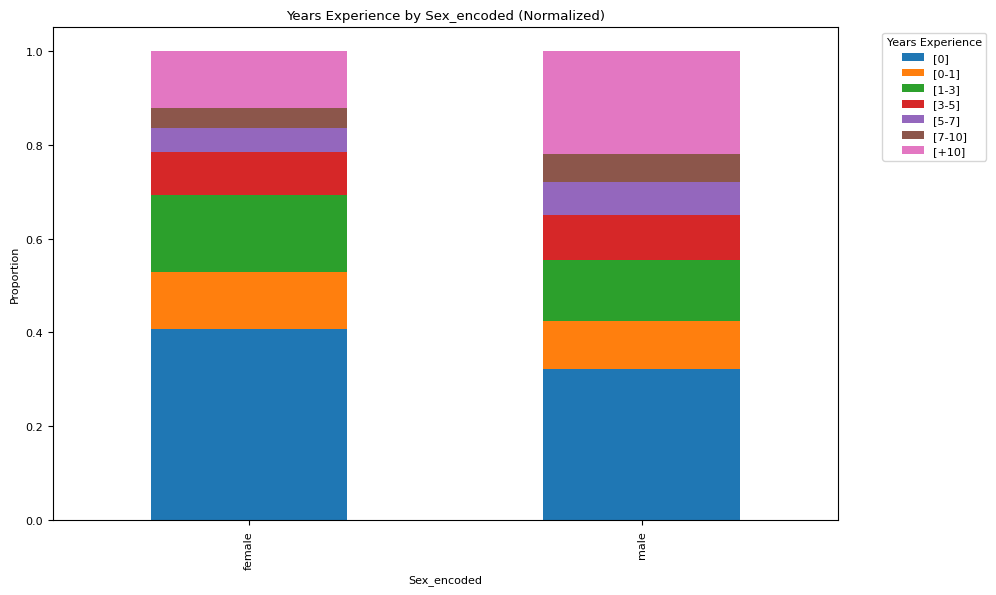

In [ ]:
plot_bar_norm(data_set, 'Sex_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

###Age Range

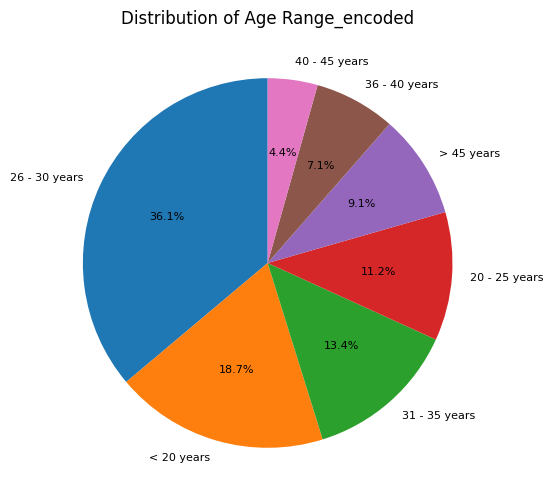

In [ ]:
getPie(data_set, 'Age Range_encoded', reverse_mapping)

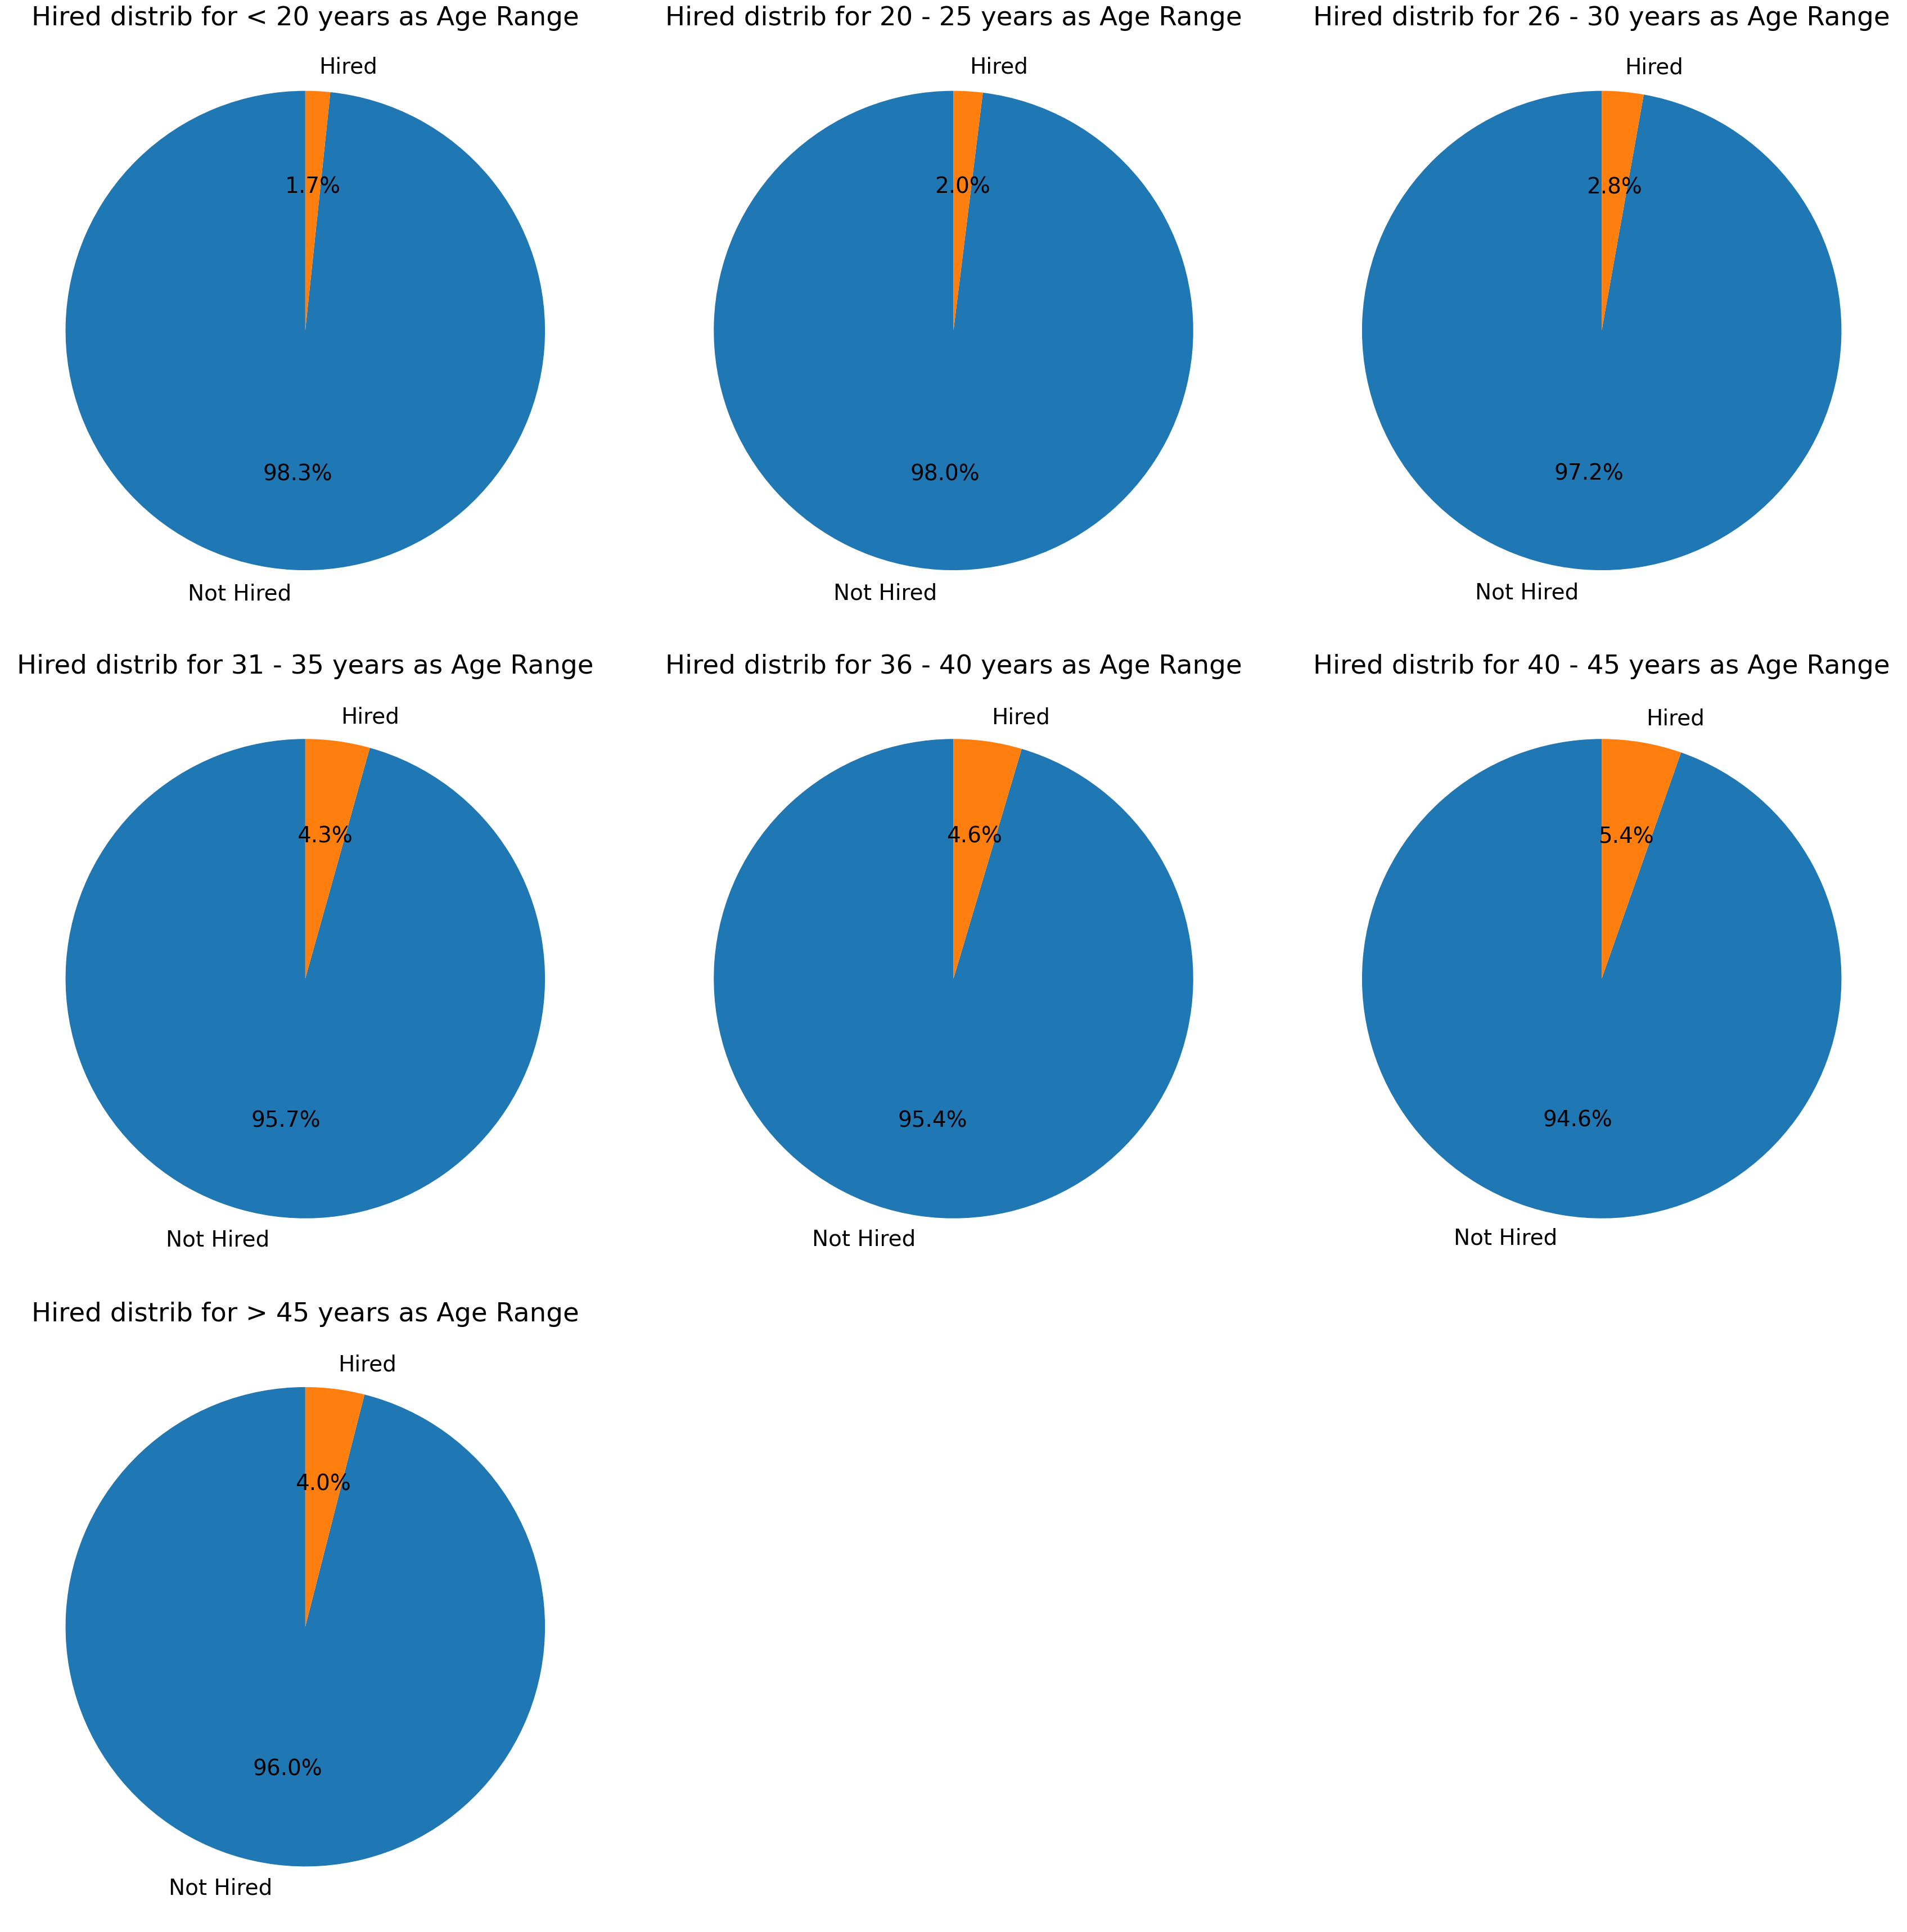

In [ ]:
plot_category_distributions(data_set, 'Age Range_encoded', 'Hired', encoding_mappings, reverse_mapping)

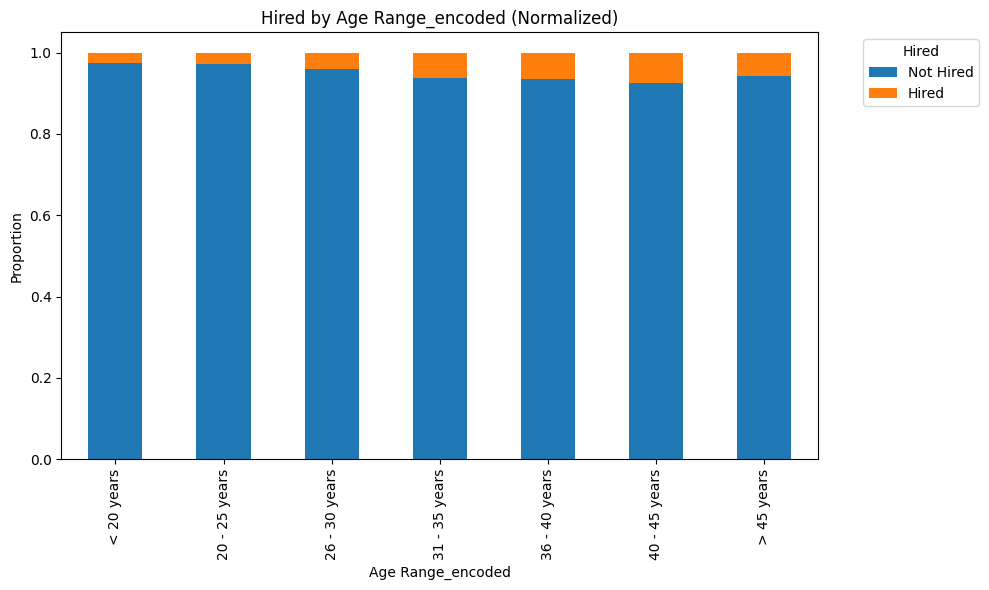

In [ ]:
plot_bar_norm(data_set, 'Age Range_encoded', 'Hired', encoding_mappings, reverse_mapping)

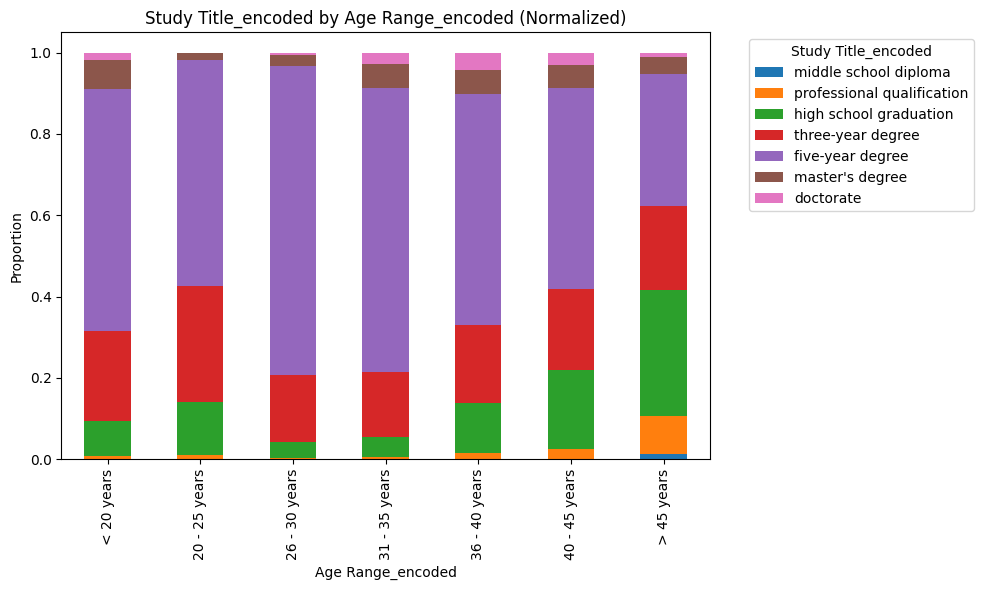

In [ ]:
plot_bar_norm(data_set, 'Age Range_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

###Protected Category

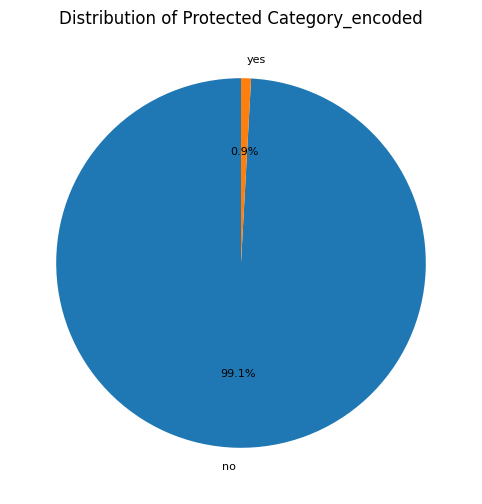

In [ ]:
getPie(data_set, 'Protected Category_encoded', reverse_mapping)

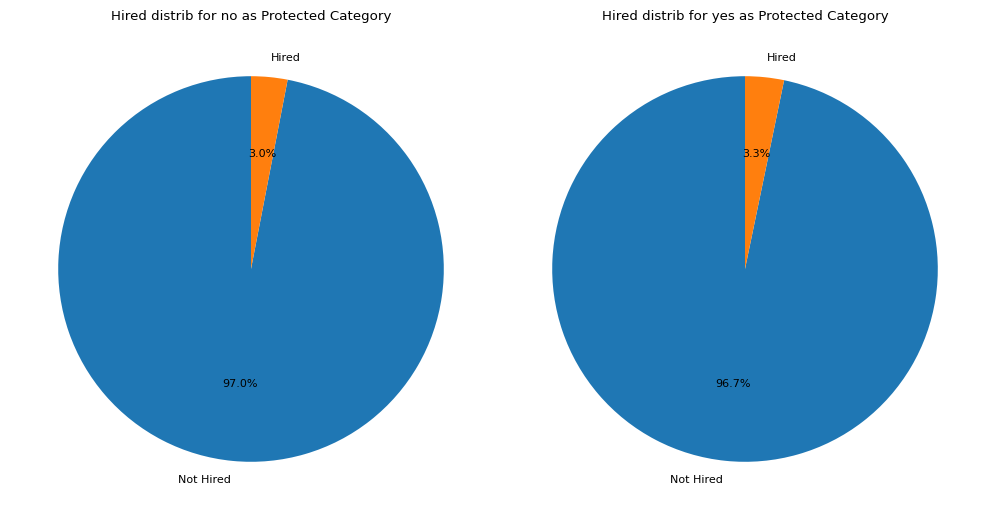

In [ ]:
plot_category_distributions(data_set, 'Protected Category_encoded', 'Hired', encoding_mappings, reverse_mapping)

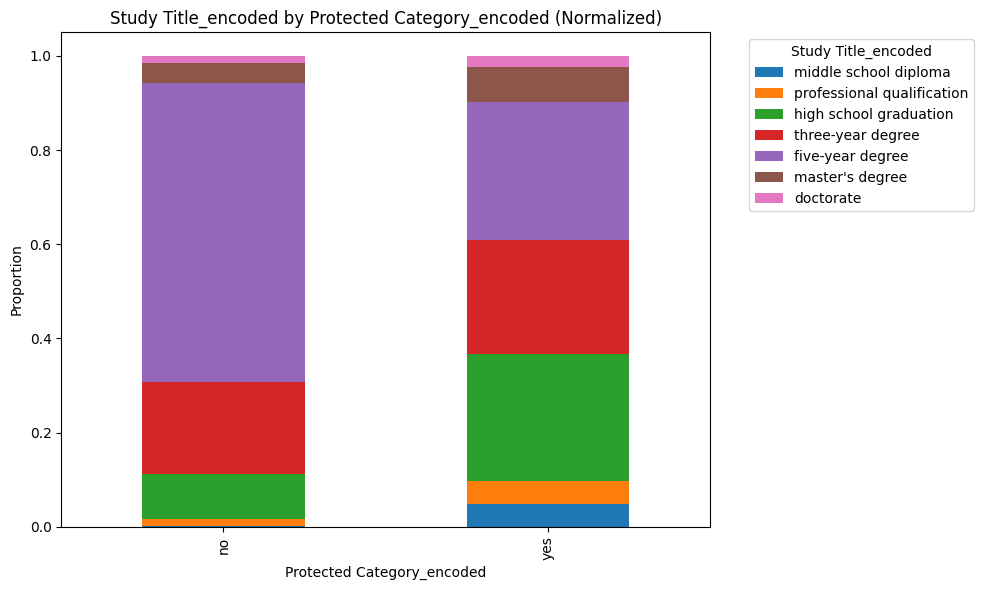

In [ ]:
plot_bar_norm(data_set, 'Protected Category_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

In [ ]:
std_mappings['Protected Category_encoded'] = encoding_mappings['Protected Category_encoded']
reverse_std_mappings['Protected Category_encoded'] = reverse_mapping['Protected Category_encoded']

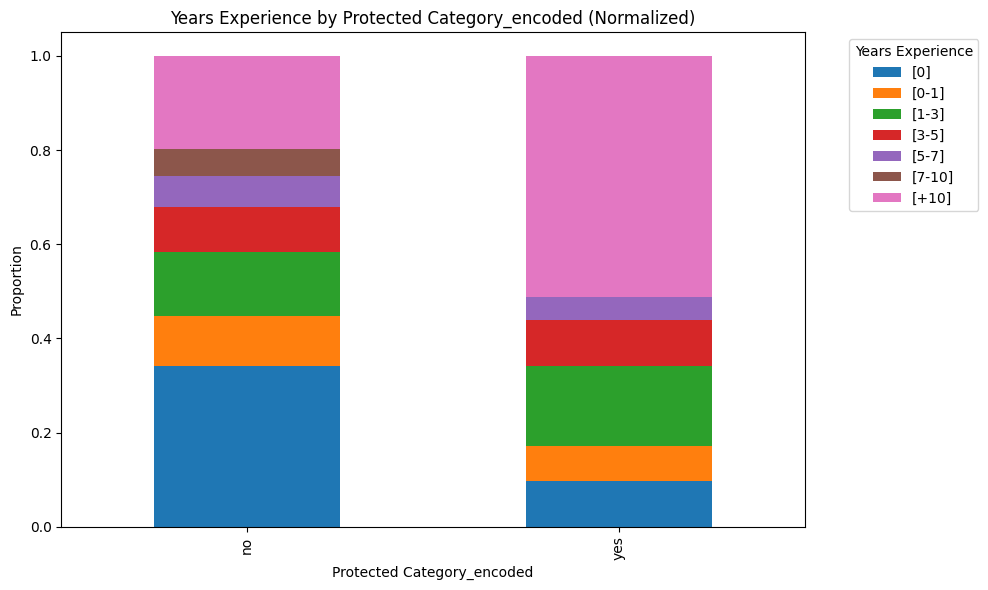

In [ ]:
plot_bar_norm(data_set, 'Protected Category_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

###Italian

In [ ]:
data_set['Italian_encoded'].value_counts()

Italian_encoded
1    13524
0      591
Name: count, dtype: int64

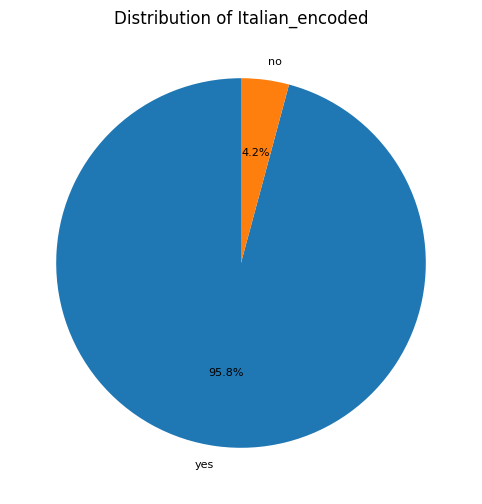

In [ ]:
getPie(data_set, 'Italian_encoded', reverse_mapping)

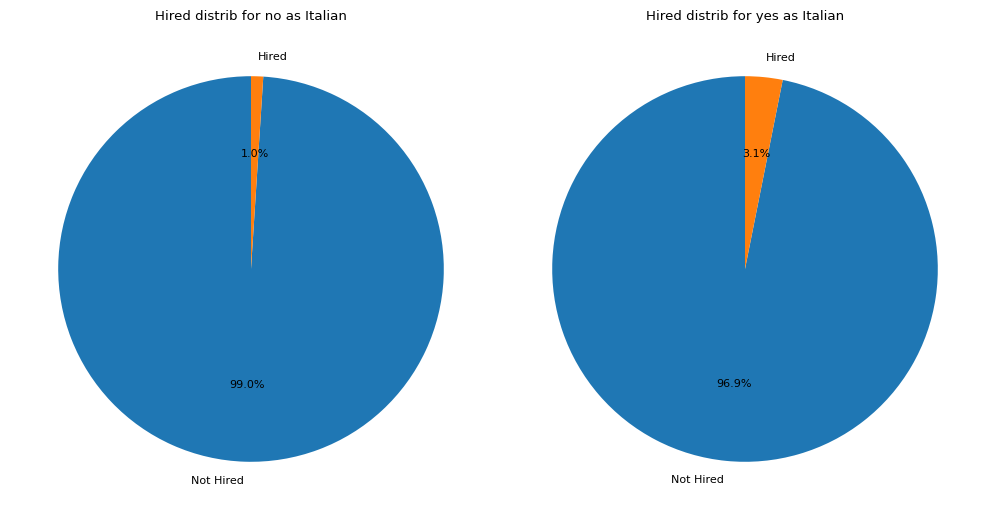

In [ ]:
plot_category_distributions(data_set, 'Italian_encoded', 'Hired', encoding_mappings, reverse_mapping)

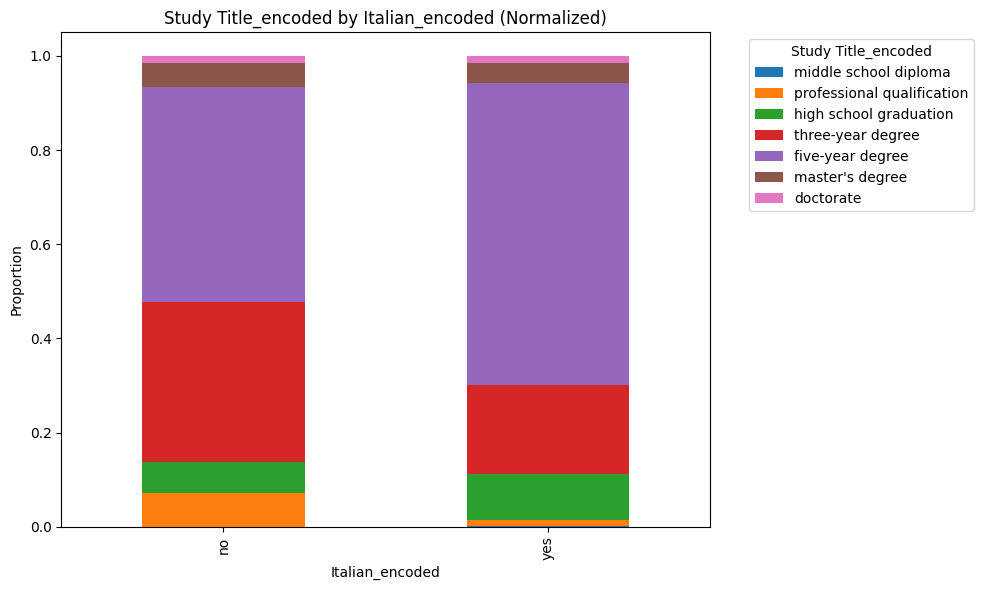

In [ ]:
plot_bar_norm(data_set, 'Italian_encoded', 'Study Title_encoded', encoding_mappings, reverse_mapping)

In [ ]:
std_mappings['Italian_encoded'] = encoding_mappings['Italian_encoded']
reverse_std_mappings['Italian_encoded'] = reverse_mapping['Italian_encoded']

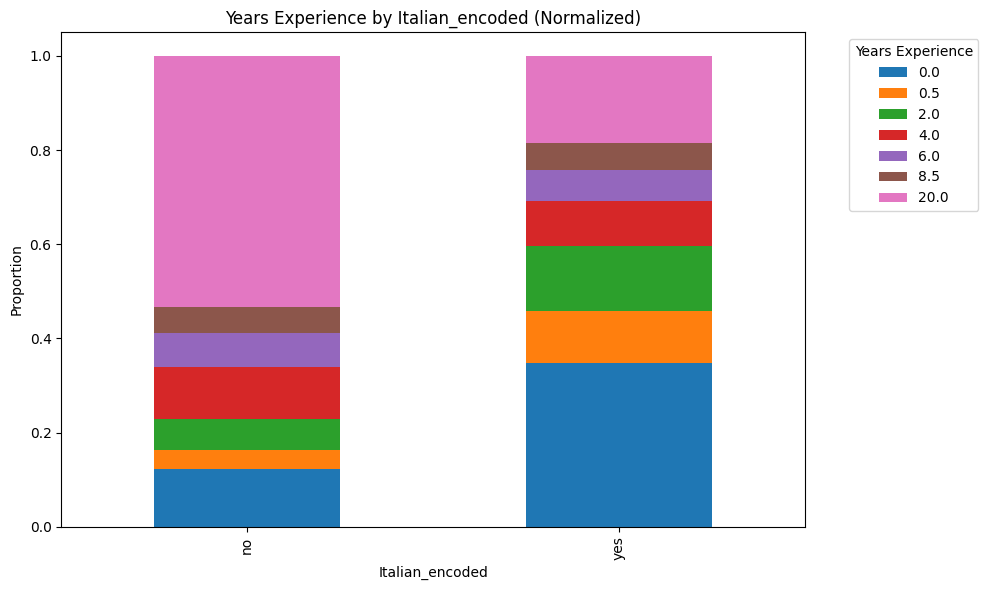

In [ ]:
plot_bar_norm(data_set, 'Italian_encoded', 'Years Experience', std_mappings, reverse_std_mappings)

##Training

### Train_Test_Split
The data is first shuffled and then resampled with ADASYN to balance the 2 classes. Then it's divided in train set and data set. The `stratify` argument is used to ensure that both the dataset have the same proportion of `Protected Category` values.

In [33]:
data_set = shuffle(data_set, random_state = random_seed)
original_ids = data_set['Id']
X = data_set.drop(columns=['Hired', 'Id'])
y = data_set['Hired']

X_res, y_res = ADASYN().fit_resample(X, y)

data_set_res = pd.concat([X_res, y_res], axis=1)
data_set_res['Id'] =original_ids

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=data_set_res[['Protected Category_encoded', 'Hired']])


###GRIDSEARCH

In [ ]:
model_list = ['dt' # decision tree
             ,'nb' # gaussian naive bayes
             ,'rf'   # random forest
             ,'lp'   # linear perceptron
             #,'svc'  # support vector
             ,'knn'  # k nearest neighbours
             ,'adb'  # adaboost
             #,'xgb' #XGBoost
             ,'lr' #Linear Regression
            ]

model_params = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state),
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-12,-1)]}]
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(random_state=random_state),
           'param': [{'early_stopping': [True,False],'class_weight':[None,'balanced']}],
          },
    'svc':{'name': 'Support Vector      ',
           'estimator': SVC(random_state=random_state),
           'param': [{'kernel': ['rbf'],
                    'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100],
                    },
                   ]
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
       },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': [{'n_estimators':[20,30,40,50]
                     ,'learning_rate':[0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=random_state),
           'param': [{
                      'max_depth': [*range(4,30,4)],
                      'n_estimators':[*range(10,30,5)],
                      'class_weight': [None,'balanced']
                      }]
          },
    'xgb': {'name': 'XGBoost             ',
           'estimator': XGBClassifier(random_state=random_state),
           'param': [{
                      'max_depth': [*range(4,30,4)],
                      'n_estimators':[*range(10,30,5)]
                      }]
          },
    'lr': {'name': 'Linear Regression   ',
           'estimator': LinearRegression(),
           'param': [{'fit_intercept': [True, False]}]
          }

}


In [ ]:
scorings = ['accuracy'
            ,'precision_macro'
            ,'recall_macro'
            ,'f1_macro'
            ]

In [ ]:
from sklearn.model_selection import ParameterGrid
trials = {m: len(list(ParameterGrid(model_params[m]['param']))) for m in model_list}
trials

{'dt': 38, 'nb': 9, 'rf': 56, 'lp': 4, 'knn': 6, 'adb': 20, 'lr': 2}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
clfs = []
predictions = {}

for scoring in scorings:
    for m in model_list:
        print(f"Training model: {model_params[m]['name']} with scoring: {scoring}")

        clf = GridSearchCV(
            model_params[m]['estimator'],
            model_params[m]['param'],
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )

        clf.fit(X_train, y_train)
        y_true, y_pred = y_test, clf.predict(X_test)
        if m == 'lr':
          y_pred = (y_pred > 0.5).astype(int)

        if m not in predictions:
            predictions[m] = {}
        predictions[m][scoring] = y_pred
        cr = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        results.append({
            'scoring': scoring,
            'model': model_params[m]['name'],
            'best_params': clf.best_params_,
            'accuracy': cr['accuracy'],
            'precision': cr['macro avg']['precision'],
            'recall': cr['macro avg']['recall'],
            'f1_score': cr['macro avg']['f1-score']
            #,'roc_auc': cr['macro avg']['roc_auc']
        })

        clfs.append(clf)

results_df = pd.DataFrame(results)


Training model: Decision Tree        with scoring: accuracy
Training model: Gaussian Naive Bayes with scoring: accuracy
Training model: Random forest        with scoring: accuracy
Training model: Linear Perceptron    with scoring: accuracy
Training model: K Nearest Neighbor  with scoring: accuracy
Training model: AdaBoost            with scoring: accuracy
Training model: Linear Regression    with scoring: accuracy


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Training model: Decision Tree        with scoring: precision_macro
Training model: Gaussian Naive Bayes with scoring: precision_macro
Training model: Random forest        with scoring: precision_macro
Training model: Linear Perceptron    with scoring: precision_macro
Training model: K Nearest Neighbor  with scoring: precision_macro
Training model: AdaBoost            with scoring: precision_macro
Training model: Linear Regression    with scoring: precision_macro


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Training model: Decision Tree        with scoring: recall_macro
Training model: Gaussian Naive Bayes with scoring: recall_macro
Training model: Random forest        with scoring: recall_macro
Training model: Linear Perceptron    with scoring: recall_macro
Training model: K Nearest Neighbor  with scoring: recall_macro
Training model: AdaBoost            with scoring: recall_macro
Training model: Linear Regression    with scoring: recall_macro


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


Training model: Decision Tree        with scoring: f1_macro
Training model: Gaussian Naive Bayes with scoring: f1_macro
Training model: Random forest        with scoring: f1_macro
Training model: Linear Perceptron    with scoring: f1_macro
Training model: K Nearest Neighbor  with scoring: f1_macro
Training model: AdaBoost            with scoring: f1_macro
Training model: Linear Regression    with scoring: f1_macro


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


In [ ]:
for score in scorings:
    scoring_filter = score
    display(results_df[results_df.scoring==scoring_filter]\
                .sort_values(by='f1_score',ascending=False)\
                .drop('scoring',axis=1)\
                .style.format(precision=3)\
                .set_caption('\nResults for scoring "{}"'.format(scoring_filter)))

In [ ]:
model = CustomKerasClassifier(input_shape=(X_train.shape[1],))

param_grid = {
    'neurons': [128],
    'activation': ['relu'],
    'optimizer': ['adam'],
    'batch_size': [16, 32, 64],
    'epochs': [10, 15, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best params: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")


Epoch 1/20
342/342 [==============================] - 7s 7ms/step - loss: 0.3115 - accuracy: 0.8621
Epoch 2/20
342/342 [==============================] - 2s 6ms/step - loss: 0.1797 - accuracy: 0.9265
Epoch 3/20
342/342 [==============================] - 1s 4ms/step - loss: 0.1457 - accuracy: 0.9420
Epoch 4/20
342/342 [==============================] - 1s 4ms/step - loss: 0.1209 - accuracy: 0.9511
Epoch 5/20
342/342 [==============================] - 1s 4ms/step - loss: 0.1060 - accuracy: 0.9591
Epoch 6/20
342/342 [==============================] - 1s 4ms/step - loss: 0.0906 - accuracy: 0.9658
Epoch 7/20
342/342 [==============================] - 1s 4ms/step - loss: 0.0791 - accuracy: 0.9705
Epoch 8/20
342/342 [==============================] - 1s 4ms/step - loss: 0.0743 - accuracy: 0.9716
Epoch 9/20
342/342 [==============================] - 1s 4ms/step - loss: 0.0646 - accuracy: 0.9764
Epoch 10/20
342/342 [==============================] - 2s 6ms/step - loss: 0.0569 - accuracy: 0.9789

###Best Models

In [34]:
best_model_params = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(random_state=random_state, max_depth=12, class_weight='balanced'),
          },
    'nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(var_smoothing=0.0001),
          },
    'lp': {'name': 'Linear Perceptron',
           'estimator': Perceptron(random_state=random_state, class_weight='balanced', early_stopping=False),
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(n_neighbors=1),
       },
    'adb':{'name': 'AdaBoost',
           'estimator': AdaBoostClassifier(random_state=random_state, learning_rate=1.5, n_estimators=50),
          },
    'rf': {'name': 'Random forest',
           'estimator': RandomForestClassifier(random_state=random_state, class_weight='balanced', max_depth=28, n_estimators=25),
          },
    'lr': {'name': 'Linear Regression',
           'estimator': LinearRegression(fit_intercept=True),
          }
}


In [35]:
models = {best_model_params[m]['name']: best_model_params[m]['estimator'] for m in best_model_params.keys()}

In [36]:
metrics = []
predictions = {}

for name, model in models.items():
    fit_predict_model(name, model, X_train, y_train, X_test, y_test, metrics, predictions)

metrics = pd.DataFrame(metrics)


Fitting Decision Tree...
Fitting Gaussian Naive Bayes...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...
Fitting Random forest...
Fitting Linear Regression...


In [37]:
metrics

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0         Decision Tree     0.987      0.989   0.986     0.987    0.986
1  Gaussian Naive Bayes     0.793      0.723   0.950     0.821    0.899
2     Linear Perceptron     0.900      0.924   0.873     0.897    0.900
3    K Nearest Neighbor     0.975      0.961   0.989     0.975    0.975
4              AdaBoost     0.984      0.993   0.976     0.984    0.998
5         Random forest     0.994      0.998   0.990     0.994    0.999
6     Linear Regression     0.874      0.912   0.828     0.868    0.957

####Neural Networks

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [40]:
best_params= {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 128, 'optimizer': 'adam'}

neural_models = []
neural_predictions = []
histories = []

i = 0
for seed in range(85, 88):
#for seed in range(85, 92):
    name = f'Neural Network {i+1}'
    i+=1
    fit_nn(name, seed, neural_models, histories, X_train, y_train, X_test, neural_predictions, best_params)

Fitting model Neural Network 1...
Epoch 1/20
257/257 [==============================] - 4s 6ms/step - loss: 0.3371 - accuracy: 0.8484 - val_loss: 0.3107 - val_accuracy: 0.8712
Epoch 2/20
257/257 [==============================] - 1s 5ms/step - loss: 0.2125 - accuracy: 0.9152 - val_loss: 0.2926 - val_accuracy: 0.8802
Epoch 3/20
257/257 [==============================] - 1s 5ms/step - loss: 0.1673 - accuracy: 0.9339 - val_loss: 0.2364 - val_accuracy: 0.8985
Epoch 4/20
257/257 [==============================] - 2s 7ms/step - loss: 0.1416 - accuracy: 0.9445 - val_loss: 0.1496 - val_accuracy: 0.9427
Epoch 5/20
257/257 [==============================] - 2s 8ms/step - loss: 0.1156 - accuracy: 0.9552 - val_loss: 0.1499 - val_accuracy: 0.9405
Epoch 6/20
257/257 [==============================] - 2s 7ms/step - loss: 0.1042 - accuracy: 0.9610 - val_loss: 0.4187 - val_accuracy: 0.8456
Epoch 7/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0948 - accuracy: 0.9636 - val_loss: 0.

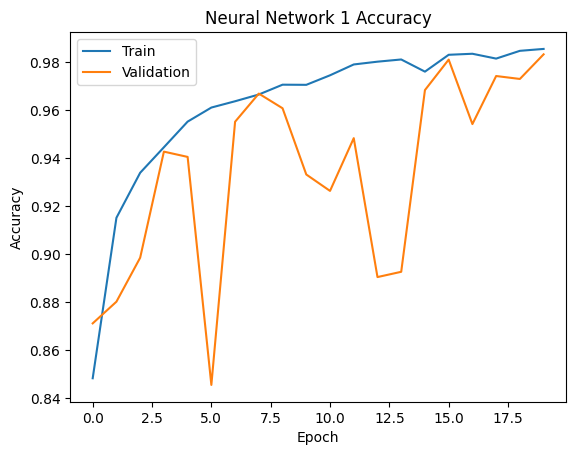

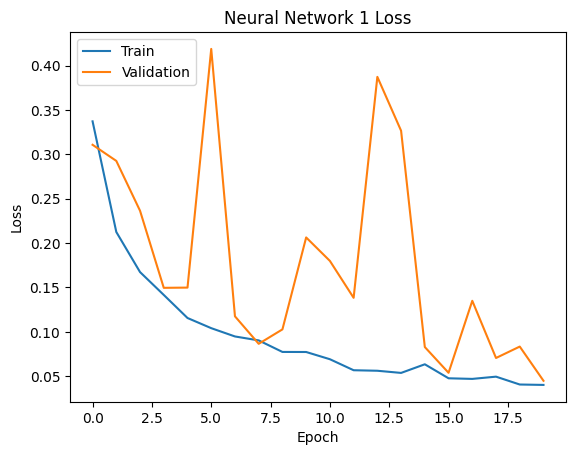

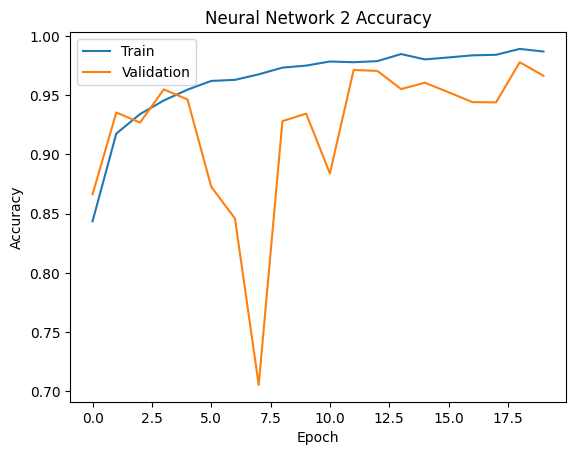

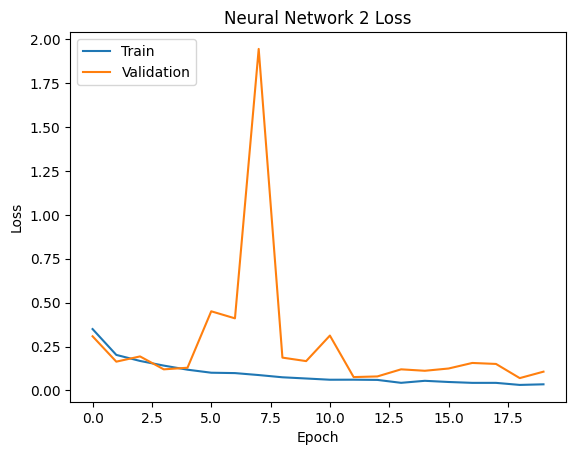

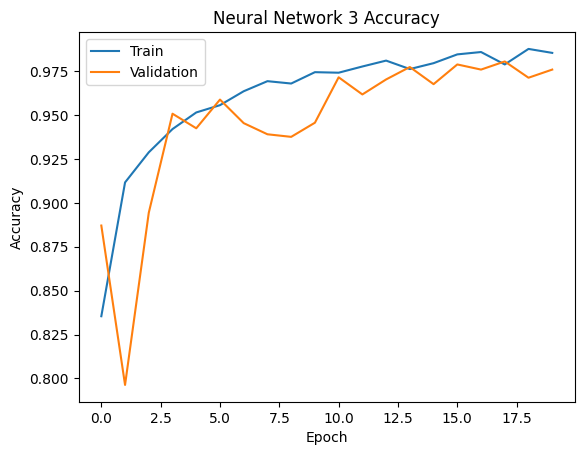

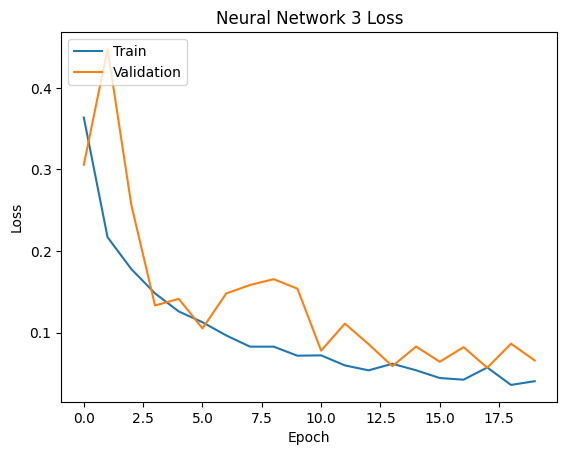

In [41]:
for i, h in enumerate(histories):
  name = f"Neural Network {i+1}"
  plot_val_train(h, name)

### NN export

In [42]:
for i, model in enumerate(neural_models):
  model.save(f'NNs/neural_network_model{i}')

In [43]:
!cp -r NNs/ $drive_dir

###NN import

In [38]:
source_path = drive_dir + 'NNs/'
!cp -r $source_path NNs/

In [ ]:
neural_models = []

for i in range(0,3):
  source_path = f'new_NNs/new_NNs/neural_network_model{i}'
  model = load_model(source_path)
  neural_models.append(model)


###NN predictions

In [44]:
i = 0
neural_predictions = []
for nn in neural_models:
  name = f"Neural Network {i}"
  predict_nn(name, nn, X_test, neural_predictions)
  i+=1

Predicting with model Neural Network 0...
214/214 [==============================] - 1s 3ms/step
Predictions from model Neural Network 0 stored.


Predicting with model Neural Network 1...
214/214 [==============================] - 0s 2ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
214/214 [==============================] - 1s 2ms/step
Predictions from model Neural Network 2 stored.




In [45]:
nn_metrics = []

for i, y_pred in enumerate(neural_predictions):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics, name)

nn_metrics = pd.DataFrame(nn_metrics)
nn_metrics

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Neural Network 1     0.984      0.985   0.984     0.984    0.984
1  Neural Network 2     0.967      0.983   0.950     0.966    0.967
2  Neural Network 3     0.976      0.979   0.972     0.976    0.976

###Performance

In [46]:
combined_metrics = pd.concat([metrics, nn_metrics], ignore_index=True)
combined_metrics

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0         Decision Tree     0.987      0.989   0.986     0.987    0.986
1  Gaussian Naive Bayes     0.793      0.723   0.950     0.821    0.899
2     Linear Perceptron     0.900      0.924   0.873     0.897    0.900
3    K Nearest Neighbor     0.975      0.961   0.989     0.975    0.975
4              AdaBoost     0.984      0.993   0.976     0.984    0.998
5         Random forest     0.994      0.998   0.990     0.994    0.999
6     Linear Regression     0.874      0.912   0.828     0.868    0.957
7      Neural Network 1     0.984      0.985   0.984     0.984    0.984
8      Neural Network 2     0.967      0.983   0.950     0.966    0.967
9      Neural Network 3     0.976      0.979   0.972     0.976    0.976

In [47]:
for i,model in enumerate(neural_models):
  models[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions):
  predictions[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection

In [48]:
# Columns groups of interest
sensitive_features = ['Sex_encoded', 'Age Range_encoded', 'Italian_encoded', 'European Residence_encoded', 'Protected Category_encoded']
non_sensitive_features = data_set.columns.difference(sensitive_features)

# Tresholds
tolerance = 0.1
significance_level = 0.1

###Demographic Parity

In [68]:
getFairnessTab(calculate_demographic_parity,
               models=models,
               sensitive_features = sensitive_features,
               predictions= predictions,
               index=list(models.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Sex_encoded
female: 0.6985714285714286
male: 0.4086203253750264
Model unfair to: male


===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Age Range_encoded
< 20 years: 0.3155694879832811
20 - 25 years: 0.5659928656361475
26 - 30 years: 0.5252603162360201
31 - 35 years: 0.51875
36 - 40 years: 0.5326460481099656
40 - 45 years: 0.6442048517520216
> 45 years: 0.4045368620037807
Model unfair to: < 20 years


===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Italian_encoded
no: 0.255
yes: 0.5050505050505051
Model unfair to: no


===============================UNFAIR!===============================
Mod

Sex_encoded Age Range_encoded Italian_encoded  \
Decision Tree               male        < 20 years              no   
Gaussian Naive Bayes        male        > 45 years              no   
Linear Perceptron           male        < 20 years              no   
K Nearest Neighbor          male        < 20 years              no   
AdaBoost                    male        < 20 years              no   
Random forest               male        < 20 years              no   
Linear Regression           male        < 20 years              no   
Neural Network 1            male        < 20 years              no   
Neural Network 2            male        < 20 years              no   
Neural Network 3            male        < 20 years              no   

                     European Residence_encoded Protected Category_encoded  
Decision Tree                      non-european                        yes  
Gaussian Naive Bayes               non-european                        yes  
Linear Perceptron                  non-european                        yes  
K Nearest Neighbor                 non-european                        yes  
AdaBoost                           non-european                        yes  
Random forest                      non-european                        yes  
Linear Regression                  non-european                        yes  
Neural Network 1                   non-european                        yes  
Neural Network 2                   non-european                        yes  
Neural Network 3                   non-european                        yes

### Equalized Odds

In [114]:
getFairnessTab(calculate_equalized_odds,
               models=models,
               sensitive_features = sensitive_features,
               predictions= predictions,
               index=list(models.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Protected Category_encoded
Maximum TPR difference: 0.9859 between group no and group yes
Model unfair to: yes
TPR and FPR for each group:
Group no: TPR=0.9859, FPR=0.0115
Group yes: TPR=0.0000, FPR=0.0000


===============================UNFAIR!===============================
Model GaussianNB(var_smoothing=0.0001) unfair wrt Sex_encoded
Maximum FPR difference: 0.3230 between group female and group male
Model unfair to: male
TPR and FPR for each group:
Group female: TPR=0.9611, FPR=0.6256
Group male: TPR=0.9408, FPR=0.3026


===============================UNFAIR!===============================
Model GaussianNB(var_smoothing=0.0001) unfair wrt Italian_encoded
Maximum TPR difference: 0.9057 between group yes and group no
Model unfair to: no
Maximum FPR difference: 0.3787 between group yes and group no
Model unfair to: no
TPR 

Sex_encoded Age Range_encoded Italian_encoded  \
Decision Tree                                                        
Gaussian Naive Bayes        male                                no   
Linear Perceptron                                                    
K Nearest Neighbor                                                   
AdaBoost                                                             
Random forest                                                        
Linear Regression                                                    
Neural Network 1                                                     
Neural Network 2                                                     
Neural Network 3                                                     

                     Protected Category_encoded  
Decision Tree                               yes  
Gaussian Naive Bayes                        yes  
Linear Perceptron                                
K Nearest Neighbor                               
AdaBoost                                    yes  
Random forest                               yes  
Linear Regression                           yes  
Neural Network 1                            yes  
Neural Network 2                                 
Neural Network 3                            yes

###Counterfactual Fairness

In [150]:
getFairnessTab(
    calculate_counterfactual_fairness,
    models=models,
    sensitive_features= sensitive_features,
    predictions=predictions,
    index=list(models.keys()),
    X_test=X_test,
    significance_level=significance_level,
    tolerance=tolerance,
    verbose=True
)

Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 0.9586
Most inaccurate group: female 0.0183
Most discriminated group: male 0.0130
Most privileged group: female 0.0183
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 0.9602
Most inaccurate group: < 20 years 0.0170
Most discriminated group: 26 - 30 years 0.0129
Most privileged group: < 20 years 0.0170
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Counterfactual Fairness on Italian_encoded
Counterfactual consistency: 0.9630
Most inaccurate group: yes 0.0148
Most discriminated group: yes 0.0148
Most privileged group: yes 0.0148
Direction of bias 

Sex_encoded  \
Decision Tree                                            
Gaussian Naive Bayes  (male, -0.1512, female, -0.0657)   
Linear Perceptron     (male, -0.1812, female, -0.0119)   
K Nearest Neighbor                                       
AdaBoost                                                 
Random forest                                            
Linear Regression      (male, -0.0947, female, 0.0767)   
Neural Network 1                                         
Neural Network 2                                         
Neural Network 3                                         

                                                  Age Range_encoded  \
Decision Tree                                                         
Gaussian Naive Bayes        (< 20 years, -0.1752, > 45 years, -0.1)   
Linear Perceptron         (< 20 years, -0.1967, > 45 years, 0.0072)   
K Nearest Neighbor      (> 45 years, -0.138, 26 - 30 years, 0.0558)   
AdaBoost                                                              
Random forest                                                         
Linear Regression         (< 20 years, -0.0935, > 45 years, 0.0413)   
Neural Network 1      (> 45 years, -0.1076, 26 - 30 years, -0.0085)   
Neural Network 2                                                      
Neural Network 3                                                      

                                  Italian_encoded   Protected Category_encoded  
Decision Tree                                       (yes, -0.2735, no, 0.0148)  
Gaussian Naive Bayes  (yes, -0.1303, no, -0.1184)  (yes, -0.5563, no, -0.1295)  
Linear Perceptron     (no, -0.2453, yes, -0.1139)  (yes, -0.3662, no, -0.1174)  
K Nearest Neighbor                                                              
AdaBoost                                                                        
Random forest                                                                   
Linear Regression     (no, -0.1114, yes, -0.0388)  (yes, -0.2355, no, -0.0382)  
Neural Network 1                                                                
Neural Network 2                                                                
Neural Network 3

##Explainers

###LIME (Local Interpretable Model-agnostic Explanations)
explanations for samples with index = 16,17,18, with the top 5 most relevant features.

LIME EXPLANATIONS FOR Decision Tree


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


<Figure size 500x300 with 0 Axes>

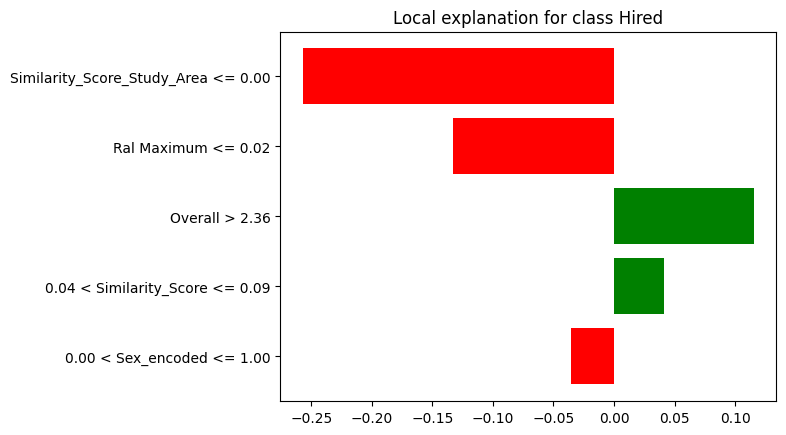

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


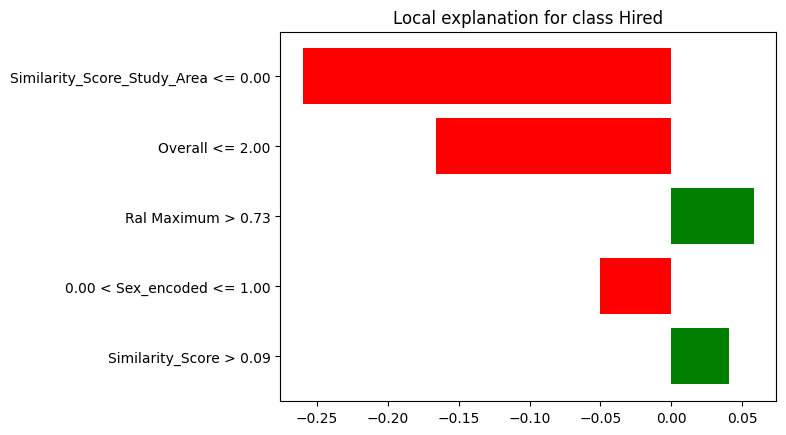

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


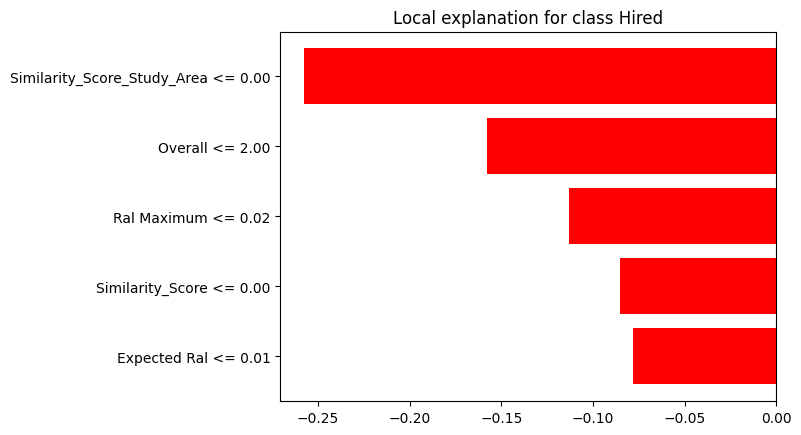

LIME EXPLANATIONS FOR Gaussian Naive Bayes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


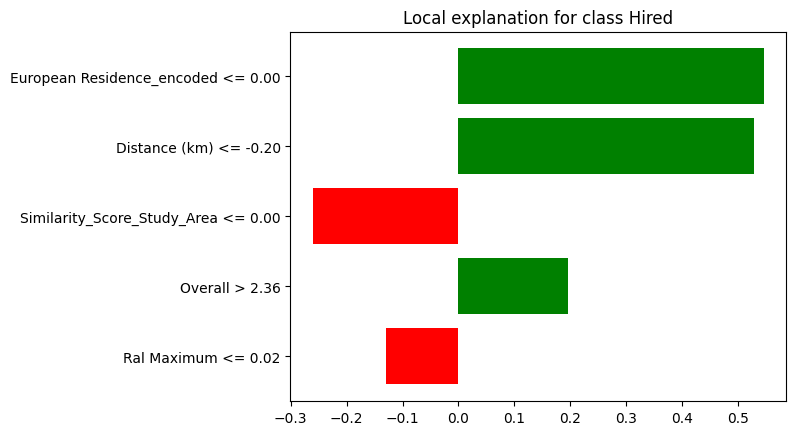

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


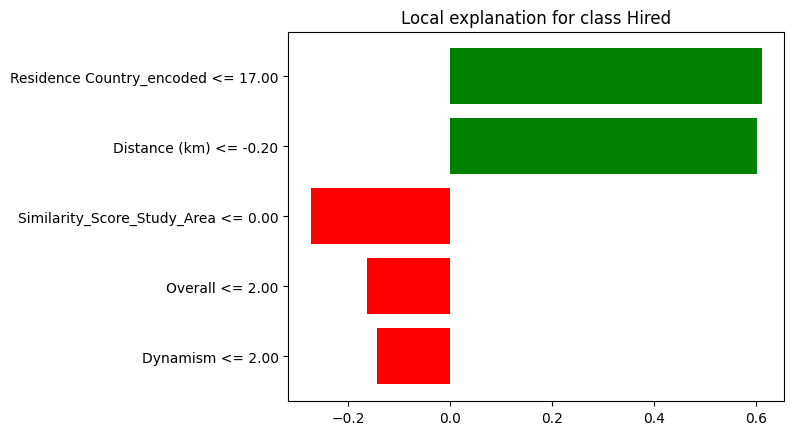

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


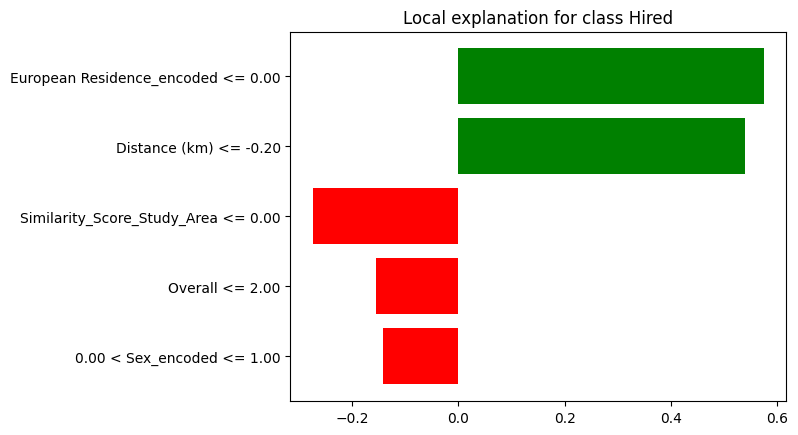

LIME EXPLANATIONS FOR K Nearest Neighbor


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


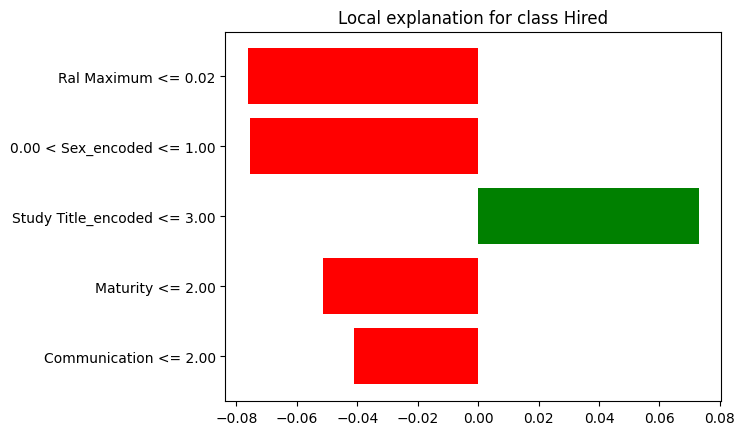

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


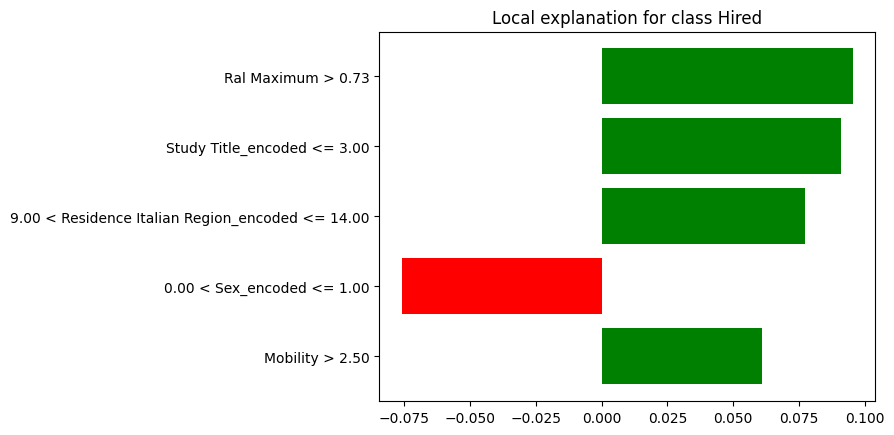

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


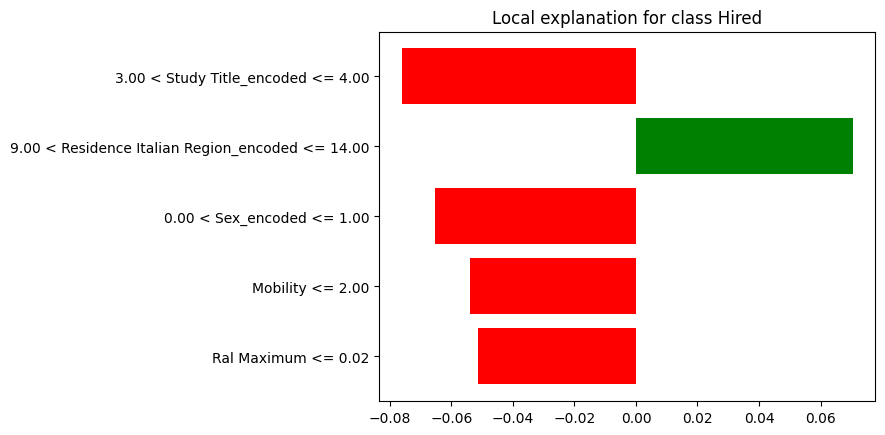

LIME EXPLANATIONS FOR AdaBoost


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


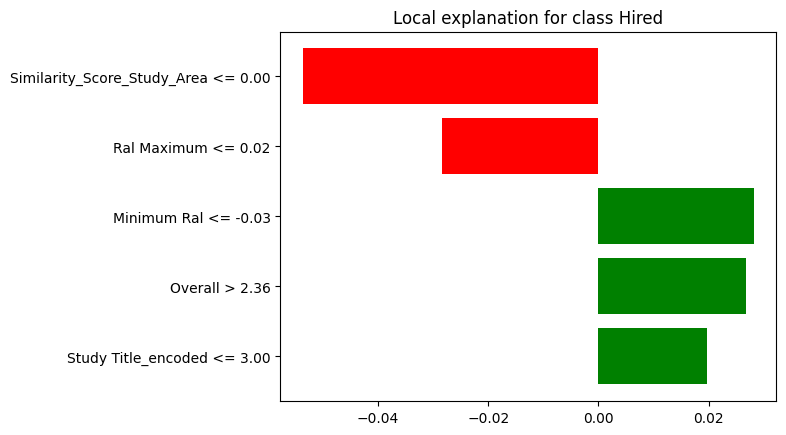

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


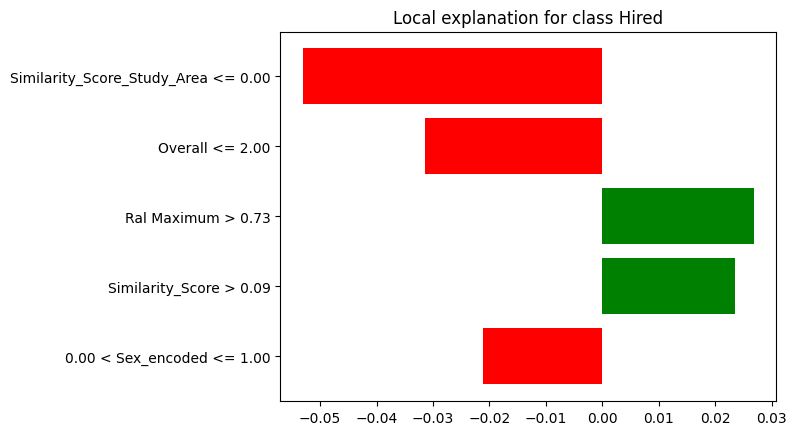

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


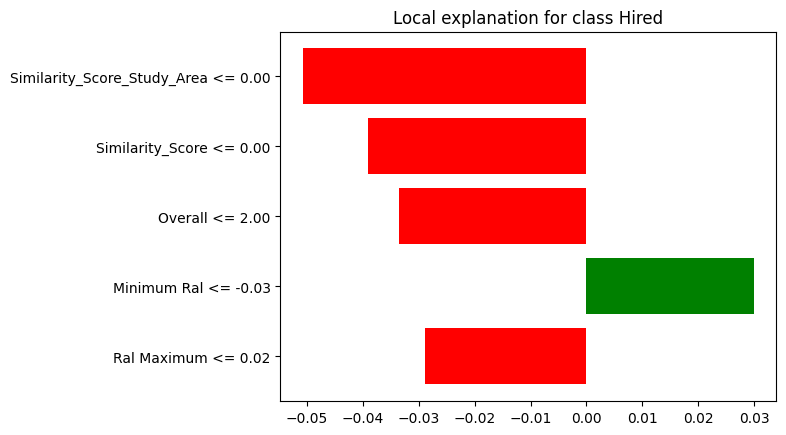

LIME EXPLANATIONS FOR Random forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


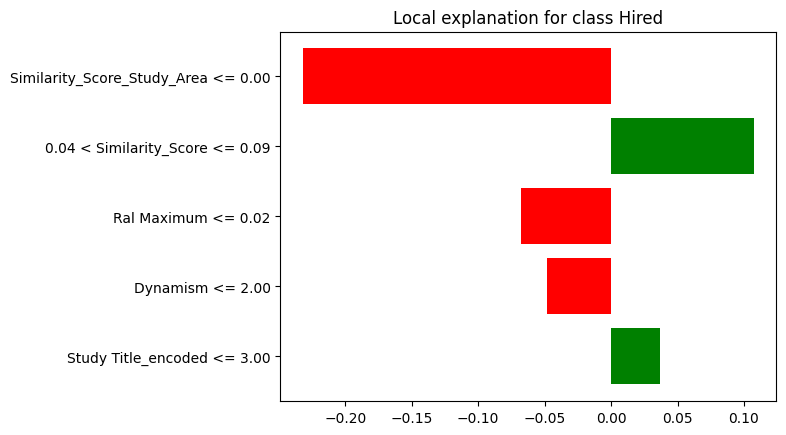

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


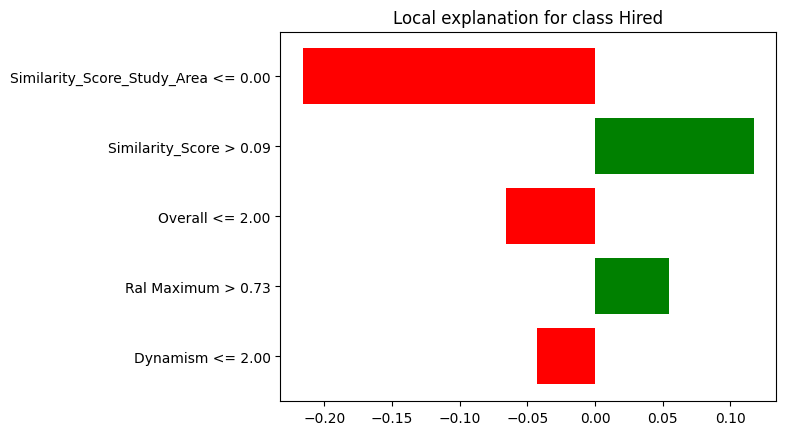

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


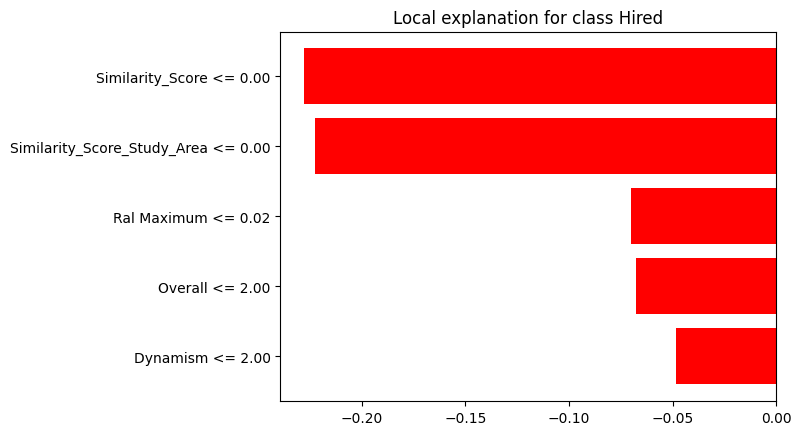

In [71]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode="classification",
    feature_names=X_train.columns.tolist(),
    class_names=['Not Hired', 'Hired'])
plt.figure(figsize=(5, 3))

for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        print(f"LIME EXPLANATIONS FOR {model_name}")
        for i in range(16,19):
            exp_dt = explainer.explain_instance(X_test.values[i], model.predict_proba, num_features=5) #Use model directly since we're iterating through values
            fig_dt = exp_dt.as_pyplot_figure()
            plt.show()

###Shap

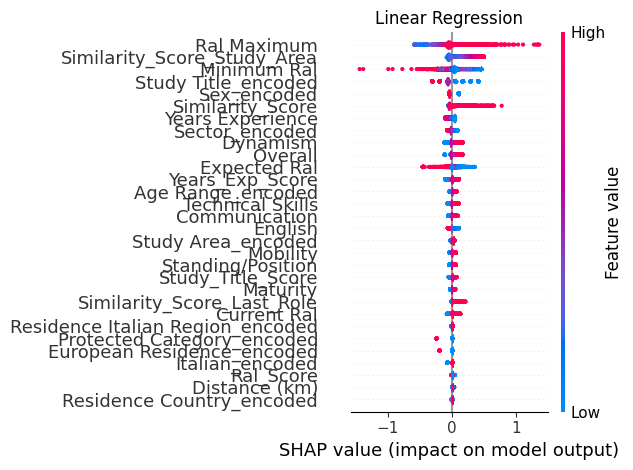

In [72]:
tot_columns = list(X_test.columns)
summaryPlot(models['Linear Regression'], X_test, tot_columns, plot_type='violin', plot_name='Linear Regression')


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 30)


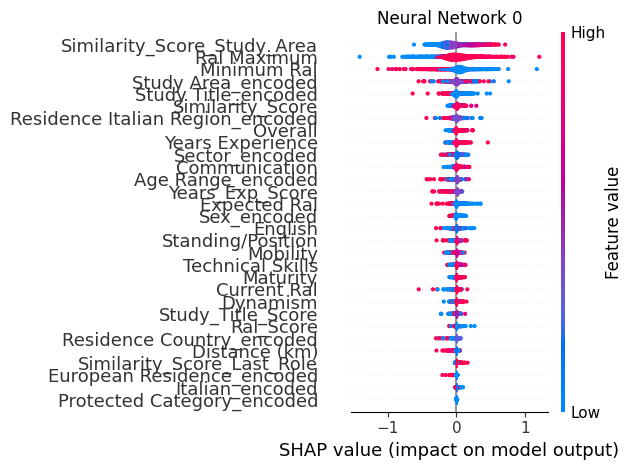

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 30)


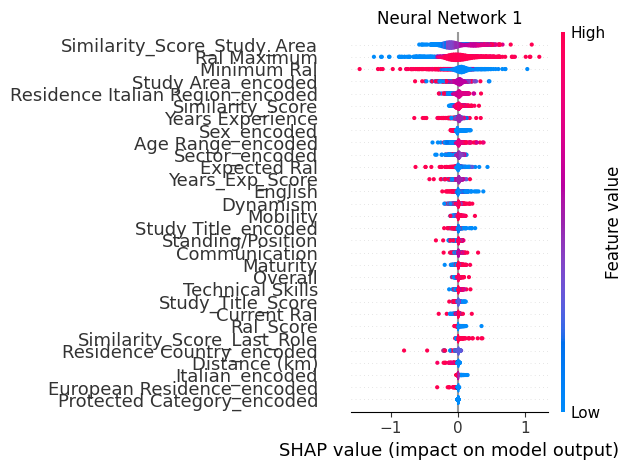

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 30)


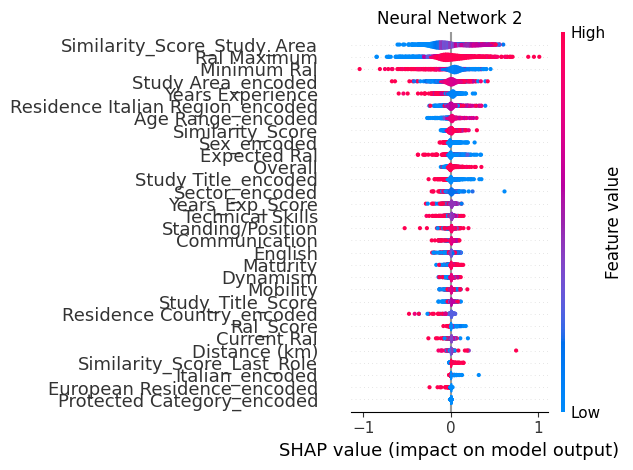

In [73]:
for i,model in enumerate(neural_models):
    summaryPlot(model, X_test.iloc[:1000], tot_columns, plot_type='violin', plot_name=f'Neural Network {i}')

##Fairness improvement

###Reweighing

In [74]:
X_train_reweighted, y_train_reweighted = reweight_dataset(X_train, y_train, sensitive_features)

In [ ]:
print("Distribution before reweighting:")
print(X_train[sensitive_features].value_counts())

print("\n\nDistribution after reweighting:")
print(X_train_reweighted[sensitive_features].value_counts())

Distribution before reweighting:
Sex_encoded  Age Range_encoded  European Residence_encoded  Protected Category_encoded
1            1                  0                           0                             3774
0            1                  0                           0                             1829
1            5                  0                           0                             1465
             2                  0                           0                             1333
             0                  0                           0                             1126
             3                  0                           0                              934
             6                  0                           0                              852
0            2                  0                           0                              796
1            4                  0                           0                              636
0            0           

In [75]:
metrics_rew = []
predictions_rew = {}
models_rew = {best_model_params[m]['name']: best_model_params[m]['estimator'] for m in best_model_params.keys()}

for name, model in models_rew.items():
    fit_predict_model(name, model, X_train_reweighted, y_train_reweighted, X_test, y_test, metrics_rew, predictions_rew)

Fitting Decision Tree...
Fitting Gaussian Naive Bayes...
Fitting Linear Perceptron...
Fitting K Nearest Neighbor...
Fitting AdaBoost...
Fitting Random forest...
Fitting Linear Regression...


In [76]:
metrics_rew = pd.DataFrame(metrics_rew)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [77]:
neural_models_rew = []
neural_predictions_rew = []
histories_rew = []
best_params= {'activation': 'relu', 'batch_size': 64, 'epochs': 20, 'neurons': 128, 'optimizer': 'adam'}

i = 0
for seed in range(85, 88):
    name = f'Neural Network {i+1}'
    i+=1
    fit_nn(name, seed, neural_models_rew, histories_rew, X_train_reweighted, y_train_reweighted, X_test, neural_predictions_rew, best_params)

Fitting model Neural Network 1...
Epoch 1/20
257/257 [==============================] - 6s 8ms/step - loss: 0.2066 - accuracy: 0.9164 - val_loss: 0.1600 - val_accuracy: 0.9315
Epoch 2/20
257/257 [==============================] - 1s 5ms/step - loss: 0.1146 - accuracy: 0.9546 - val_loss: 0.0957 - val_accuracy: 0.9539
Epoch 3/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0931 - accuracy: 0.9640 - val_loss: 0.0581 - val_accuracy: 0.9776
Epoch 4/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0738 - accuracy: 0.9718 - val_loss: 0.0699 - val_accuracy: 0.9749
Epoch 5/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0658 - accuracy: 0.9746 - val_loss: 0.0588 - val_accuracy: 0.9776
Epoch 6/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0599 - accuracy: 0.9782 - val_loss: 0.0626 - val_accuracy: 0.9746
Epoch 7/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0563 - accuracy: 0.9794 - val_loss: 0.

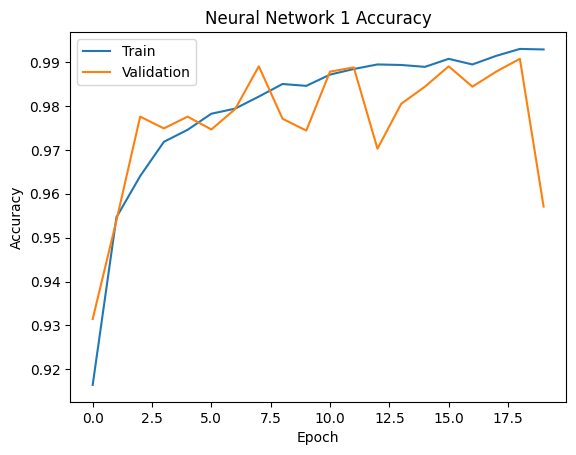

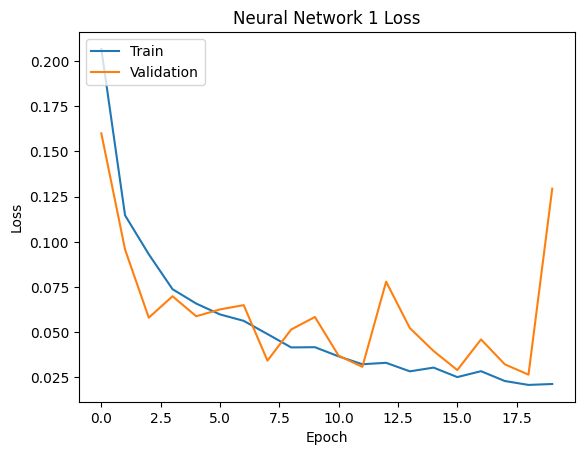

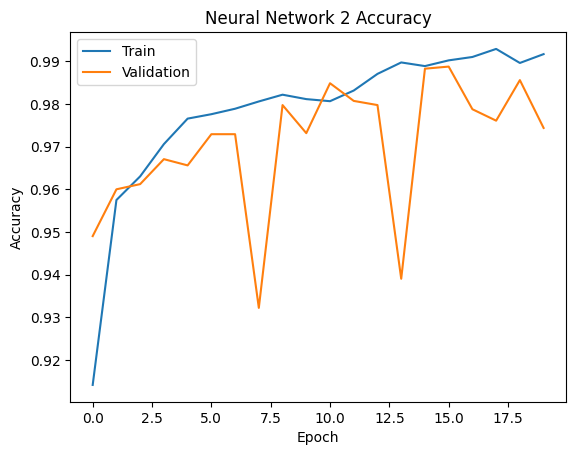

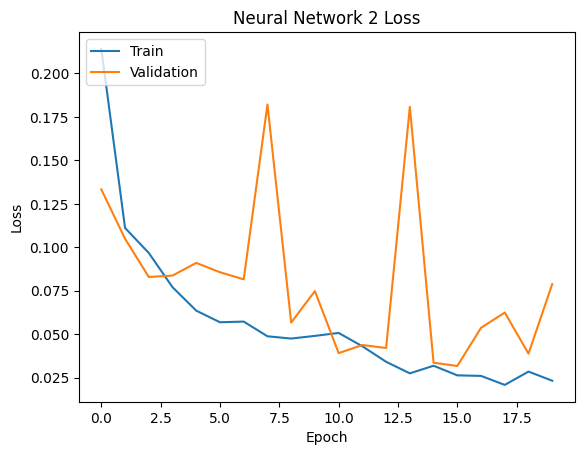

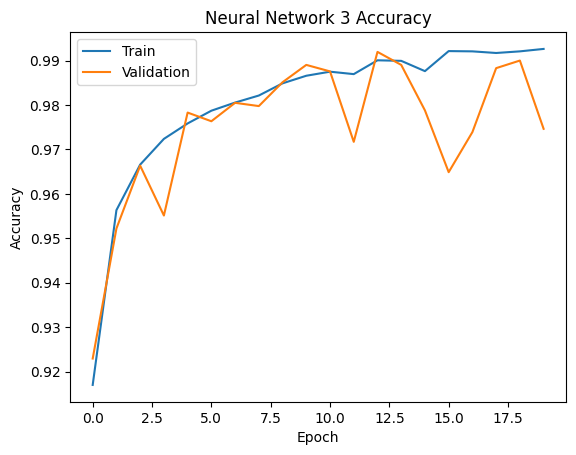

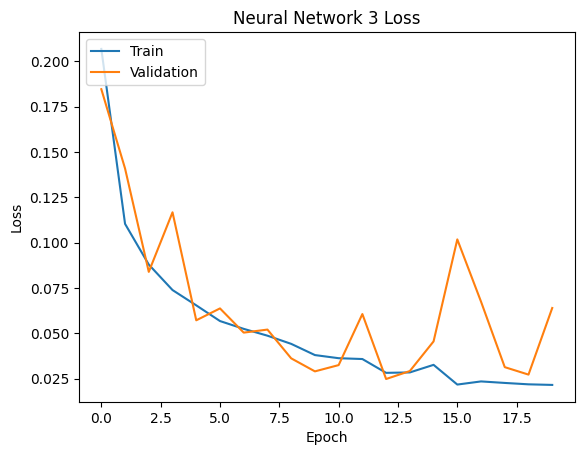

In [78]:
for i, h in enumerate(histories_rew):
  name = f"Neural Network {i+1}"
  plot_val_train(h, name)

###NN reweighted export

In [79]:
for i, model in enumerate(neural_models_rew):
  model.save(f'NNs_rew/neural_network_model_rew{i}')

In [80]:
!cp -r NNs_rew/ $drive_dir

###NN reweighted import

In [ ]:
neural_models_rew = []

for i in range(0,3):
  model = load_model(f'{drive_dir}NNs_rew/neural_network_model_rew{i}')
  neural_models_rew.append(model)


###NN reweighted predict

In [81]:
neural_predictions_rew = []
for i, model in enumerate(neural_models_rew):
  name = f"Neural Network {i+1}"
  predict_nn(name, model, X_test, neural_predictions_rew)

Predicting with model Neural Network 1...
214/214 [==============================] - 1s 2ms/step
Predictions from model Neural Network 1 stored.


Predicting with model Neural Network 2...
214/214 [==============================] - 1s 2ms/step
Predictions from model Neural Network 2 stored.


Predicting with model Neural Network 3...
214/214 [==============================] - 1s 2ms/step
Predictions from model Neural Network 3 stored.




In [82]:
nn_metrics_rew = []

for i, y_pred in enumerate(neural_predictions_rew):
  name = f"Neural Network {i+1}"
  calc_nn_metrics(y_pred, y_test, nn_metrics_rew, name)
nn_metrics_rew = pd.DataFrame(nn_metrics_rew)
nn_metrics_rew

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Neural Network 1     0.890      0.978   0.798     0.879    0.890
1  Neural Network 2     0.901      0.839   0.990     0.909    0.901
2  Neural Network 3     0.946      0.942   0.950     0.946    0.946

###Performance

In [83]:
combined_metrics_rew = pd.concat([metrics_rew, nn_metrics_rew], ignore_index=True)
combined_metrics_rew

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0         Decision Tree     0.963      0.951   0.976     0.963    0.978
1  Gaussian Naive Bayes     0.831      0.814   0.856     0.835    0.884
2     Linear Perceptron     0.819      0.950   0.674     0.788    0.819
3    K Nearest Neighbor     0.913      0.865   0.978     0.918    0.913
4              AdaBoost     0.968      0.974   0.962     0.968    0.995
5         Random forest     0.989      0.991   0.986     0.989    0.999
6     Linear Regression     0.841      0.911   0.756     0.826    0.930
7      Neural Network 1     0.890      0.978   0.798     0.879    0.890
8      Neural Network 2     0.901      0.839   0.990     0.909    0.901
9      Neural Network 3     0.946      0.942   0.950     0.946    0.946

In [84]:
for i,model in enumerate(neural_models_rew):
  models_rew[f"Neural Network {i+1}"] = model

for i, prediction_list in enumerate(neural_predictions_rew):
  predictions_rew[f"Neural Network {i+1}"] = prediction_list.flatten()

##Bias detection after REWEIGHING

###Demographic Parity

In [85]:
getFairnessTab(calculate_demographic_parity,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Sex_encoded
female: 0.700952380952381
male: 0.4289034439045003
Model unfair to: male


===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Age Range_encoded
< 20 years: 0.34691745036572624
20 - 25 years: 0.5790725326991677
26 - 30 years: 0.5337446972618588
31 - 35 years: 0.5302083333333333
36 - 40 years: 0.5567010309278351
40 - 45 years: 0.660377358490566
> 45 years: 0.41776937618147447
Model unfair to: < 20 years


===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Italian_encoded
no: 0.275
yes: 0.519674355495251
Model unfair to: no


===============================UNFAIR!=========================

Sex_encoded Age Range_encoded Italian_encoded  \
Decision Tree               male        < 20 years              no   
Gaussian Naive Bayes        male        < 20 years              no   
Linear Perceptron           male        < 20 years              no   
K Nearest Neighbor          male        < 20 years              no   
AdaBoost                    male        < 20 years              no   
Random forest               male        < 20 years              no   
Linear Regression           male        < 20 years              no   
Neural Network 1            male        < 20 years              no   
Neural Network 2            male        < 20 years              no   
Neural Network 3            male        < 20 years              no   

                     European Residence_encoded Protected Category_encoded  
Decision Tree                      non-european                        yes  
Gaussian Naive Bayes               non-european                        yes  
Linear Perceptron                  non-european                        yes  
K Nearest Neighbor                 non-european                        yes  
AdaBoost                           non-european                        yes  
Random forest                      non-european                        yes  
Linear Regression                  non-european                        yes  
Neural Network 1                   non-european                        yes  
Neural Network 2                   non-european                        yes  
Neural Network 3                   non-european                        yes

### Equalized Odds

In [86]:
getFairnessTab(calculate_equalized_odds,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Protected Category_encoded
Maximum TPR difference: 0.9762 between group no and group yes
Model unfair to: yes
TPR and FPR for each group:
Group no: TPR=0.9762, FPR=0.0507
Group yes: TPR=0.0000, FPR=0.0333


===============================UNFAIR!===============================
Model GaussianNB(var_smoothing=0.0001) unfair wrt Age Range_encoded
Maximum TPR difference: 0.2020 between group 36 - 40 years and group 20 - 25 years
Model unfair to: 20 - 25 years
TPR and FPR for each group:
Group < 20 years: TPR=0.8007, FPR=0.1951
Group 26 - 30 years: TPR=0.8415, FPR=0.1453
Group 31 - 35 years: TPR=0.9115, FPR=0.2268
Group > 45 years: TPR=0.8685, FPR=0.3101
Group 36 - 40 years: TPR=0.9589, FPR=0.2820
Group 40 - 45 years: TPR=0.9492, FPR=0.2889
Group 20 - 25 years: TPR=0.7569, FPR=0.1250


===============================UNFAIR!=====

Sex_encoded Age Range_encoded Italian_encoded  \
Decision Tree                                                        
Gaussian Naive Bayes                 20 - 25 years                   
Linear Perceptron           male                                     
K Nearest Neighbor                                                   
AdaBoost                                                             
Random forest                                                        
Linear Regression           male     20 - 25 years                   
Neural Network 1                                                     
Neural Network 2                                                     
Neural Network 3                                                     

                     European Residence_encoded Protected Category_encoded  
Decision Tree                                                          yes  
Gaussian Naive Bayes                                                   yes  
Linear Perceptron                  non-european                        yes  
K Nearest Neighbor                                                          
AdaBoost                                                               yes  
Random forest                                                          yes  
Linear Regression                      european                        yes  
Neural Network 1                       european                        yes  
Neural Network 2                                                       yes  
Neural Network 3                                                       yes

###Counterfactual Fairness

In [149]:
getFairnessTab(calculate_counterfactual_fairness,
               models=models_rew,
               sensitive_features = sensitive_features,
               predictions= predictions_rew,
               index=list(models_rew.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 0.9950
Most inaccurate group: female 0.0035
Most discriminated group: male -0.0018
Most privileged group: female 0.0035
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 0.9960
Most inaccurate group: < 20 years 0.0022
Most discriminated group: 26 - 30 years -0.0019
Most privileged group: < 20 years 0.0022
Direction of bias (negative = worse, positive = better)


Model DecisionTreeClassifier(class_weight='balanced', max_depth=12, random_state=42) unfair wrt Counterfactual Fairness on Italian_encoded
Counterfactual consistency: 1.0000
Most inaccurate group: yes 0.0000
Most discriminated group: yes 0.0000
Most privileged group: yes 0.0000
Direction of bia

Sex_encoded  \
Decision Tree                                           
Gaussian Naive Bayes                                    
Linear Perceptron     (male, -0.0637, female, 0.1057)   
K Nearest Neighbor                                      
AdaBoost                                                
Random forest                                           
Linear Regression     (male, -0.0556, female, 0.1158)   
Neural Network 1                                        
Neural Network 2                                        
Neural Network 3                                        

                                                  Age Range_encoded  \
Decision Tree                                                         
Gaussian Naive Bayes                                                  
Linear Perceptron         (< 20 years, -0.0792, > 45 years, 0.1247)   
K Nearest Neighbor     (> 45 years, -0.1885, 26 - 30 years, 0.0053)   
AdaBoost                                                              
Random forest                                                         
Linear Regression                                                     
Neural Network 1      (> 45 years, -0.1106, 26 - 30 years, -0.0094)   
Neural Network 2       (> 45 years, -0.0784, 31 - 35 years, 0.0183)   
Neural Network 3       (< 20 years, -0.1181, 31 - 35 years, 0.0019)   

                                 Italian_encoded  Protected Category_encoded  
Decision Tree                                        (yes, -0.2883, no, 0.0)  
Gaussian Naive Bayes                               (yes, -0.426, no, 0.0007)  
Linear Perceptron     (no, -0.1278, yes, 0.0037)  (yes, -0.2486, no, 0.0001)  
K Nearest Neighbor                                                            
AdaBoost                                                                      
Random forest                                                                 
Linear Regression                                 (yes, -0.1964, no, 0.0009)  
Neural Network 1                                                              
Neural Network 2      (yes, -0.0004, no, 0.1077)  (yes, -0.1042, no, 0.0007)  
Neural Network 3                                  (yes, -0.1041, no, 0.0004)

##Adversarial Debiasing

In [ ]:
epochs = 15
batch_size = 64
threshold = 0.5
logits = True

sensitive_features = ['Sex_encoded', 'Age Range_encoded', 'Italian_encoded', 'Protected Category_encoded']
sensitive_f = [X_train[col] for col in sensitive_features]

In [ ]:
def create_Main():
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    return model

def create_adversary():
    adv = Sequential([
        Dense(128, input_dim=1, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    return adv

In [ ]:
def build_batched_data(X, y, sensitive_features, batch_size, names):
    Xb, yb, sens_f, X_adv_b = [], [], [], []
    for i in range(0, len(X), batch_size):
        Xb.append(X[i:i+batch_size])
        yb.append(y[i:i+batch_size])
    for i in range(len(sensitive_features)):
        temp1, temp2 = [], []
        X_adv = X.drop(names[i], axis=1)
        for j in range(0, len(X), batch_size):
            temp1.append(X_adv[j:j+batch_size])
            temp2.append(sensitive_features[i][j:j+batch_size])
        X_adv_b.append(temp1)
        sens_f.append(temp2)
    return Xb, yb, sens_f, X_adv_b

In [ ]:
def train_nn(main, adv, X, y, sens_f, X_adv, epochs, adv_n, print_step=10):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for i in range(len(X)):
            X_batch = tf.convert_to_tensor(X[i].values, dtype=tf.float32)
            y_batch = tf.convert_to_tensor(y[i].values, dtype=tf.float32)
            sens = tf.convert_to_tensor(sens_f[adv_n][i], dtype=tf.float32)

            with tf.GradientTape(persistent=True) as tape:
                main_preds = main(X_batch, training=True)
                loss_main = loss_fcn_main(y_batch, main_preds)
                adv_preds = adv[adv_n](main_preds, training=True)
                loss_adversary = loss_fcn_adv(sens, adv_preds)
                combined_loss = tf.subtract(loss_main, tf.multiply(0.25, loss_adversary))

            #update main model
            gradients_main = tape.gradient(combined_loss, main.trainable_variables)
            optimizerM.apply_gradients(zip(gradients_main, main.trainable_variables))

            #update adversary model
            gradients_adv = tape.gradient(loss_adversary, adv[adv_n].trainable_variables)
            optimizer_list[adv_n].apply_gradients(zip(gradients_adv, adv[adv_n].trainable_variables))

            del tape

            if i % print_step == 0:
                print(f"Batch {i}/{len(X)} - Main Loss: {loss_main.numpy()}, Adversary Loss: {loss_adversary.numpy()}, Combined Loss: {combined_loss.numpy()}")


In [ ]:
#loss functions
loss_fcn_main = BinaryCrossentropy(from_logits=logits)
loss_fcn_adv = BinaryCrossentropy(from_logits=logits)

#optimizers
optimizerM = Adam(learning_rate=0.001)
optimizer_list = [Adam(learning_rate=0.0005) for _ in range(4)]

In [ ]:
#main model
np.random.seed(85)
tf.random.set_seed(85)
main_model = create_Main()
main_model.compile(optimizer=optimizerM, loss=loss_fcn_main, metrics=['accuracy'])

In [ ]:
#adversary models
adversary_models = [create_adversary() for _ in range(4)]
for adv in adversary_models:
    adv.compile(optimizer=Adam(learning_rate=0.0005), loss=loss_fcn_adv, metrics=['accuracy'])

In [ ]:
Xb, yb, sens_f, X_adv_b = build_batched_data(X_train, y_train, sensitive_f, batch_size, sensitive_features)

In [100]:
#initial adversary weights
weights = [adv.get_weights() for adv in adversary_models]

#training main model against each adversary
for j in range(4):
    print(f"\nTraining Main Model against Adversary {j}")
    train_nn(main_model, adversary_models, Xb, yb, sens_f, X_adv_b, epochs, adv_n=j, print_step=60)
    adversary_models[j].set_weights(weights[j])  #adversary weights reset


Training Main Model against Adversary 0
Epoch 1/15
Batch 0/321 - Main Loss: 0.7116818428039551, Adversary Loss: 0.805742621421814, Combined Loss: 0.5102461576461792
Batch 60/321 - Main Loss: 0.32530707120895386, Adversary Loss: 0.6275120973587036, Combined Loss: 0.16842904686927795
Batch 120/321 - Main Loss: 0.28102055191993713, Adversary Loss: 0.5764374732971191, Combined Loss: 0.13691118359565735
Batch 180/321 - Main Loss: 0.222560316324234, Adversary Loss: 0.5604199171066284, Combined Loss: 0.0824553370475769
Batch 240/321 - Main Loss: 0.31188100576400757, Adversary Loss: 0.6173673272132874, Combined Loss: 0.15753917396068573
Batch 300/321 - Main Loss: 0.2576481103897095, Adversary Loss: 0.5072810649871826, Combined Loss: 0.13082784414291382
Epoch 2/15
Batch 0/321 - Main Loss: 0.20053794980049133, Adversary Loss: 0.5286287665367126, Combined Loss: 0.06838075816631317
Batch 60/321 - Main Loss: 0.15960033237934113, Adversary Loss: 0.5942132472991943, Combined Loss: 0.0110470205545425

###Export main

In [101]:
main_model.save(f'Adversarial_Debiasing_mainNNs/neural_network_model_main')

!cp -r Adversarial_Debiasing_mainNNs/ $drive_dir

###Import main

In [ ]:
main_model = load_model(f'{drive_dir}Adversarial_Debiasing_mainNNs/neural_network_model_main')

###Main predictions

In [102]:
main_predictions = []

y_pred = (main_model.predict(X_test) > 0.5).astype("int32").squeeze()
main_predictions.append(y_pred)

214/214 [==============================] - 1s 2ms/step


In [103]:
nn_metrics_main = []

calc_nn_metrics(main_predictions[0], y_test, nn_metrics_main, 'Neural Network Main')

nn_metrics_main = pd.DataFrame(nn_metrics_main)
nn_metrics_main

Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Neural Network Main     0.968      0.943   0.996     0.969    0.968

###Demographic Parity

In [104]:
models_main = {}
models_main[f"Neural Network Main"] = main_model
predictions_main = {}
predictions_main[f"Neural Network Main"] = main_predictions[0].flatten()

In [105]:
getFairnessTab(calculate_demographic_parity,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7afbb37a6fd0> unfair wrt Sex_encoded
female: 0.7271428571428571
male: 0.43862243819987323
Model unfair to: male


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7afbb37a6fd0> unfair wrt Age Range_encoded
< 20 years: 0.3437826541274817
20 - 25 years: 0.5957193816884662
26 - 30 years: 0.5499421519475511
31 - 35 years: 0.546875
36 - 40 years: 0.5756013745704467
40 - 45 years: 0.6711590296495957
> 45 years: 0.4499054820415879
Model unfair to: < 20 years


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7afbb37a6fd0> unfair wrt Italian_encoded
no: 0.27
yes: 0.535052012663953
Model unfair to: no


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequent

Sex_encoded Age Range_encoded Italian_encoded  \
Neural Network Main        male        < 20 years              no   

                    Protected Category_encoded  
Neural Network Main                        yes

### Equalized Odds

In [106]:
getFairnessTab(calculate_equalized_odds,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

Sex_encoded Age Range_encoded Italian_encoded  \
Neural Network Main                                                 

                    Protected Category_encoded  
Neural Network Main

###Counterfactual Fairness

In [148]:
getFairnessTab(calculate_counterfactual_fairness,
               models=models_main,
               sensitive_features = sensitive_features,
               predictions= predictions_main,
               index=list(models_main.keys()),
               X_test=X_test,
               significance_level=significance_level,
               tolerance=tolerance,
               verbose=True
               )

Model <keras.src.engine.sequential.Sequential object at 0x7afbb37a6fd0> unfair wrt Counterfactual Fairness on Sex_encoded
Counterfactual consistency: 0.9618
Most inaccurate group: female 0.0370
Most discriminated group: male -0.0073
Most privileged group: female 0.0370
Direction of bias (negative = worse, positive = better)


Model <keras.src.engine.sequential.Sequential object at 0x7afbb37a6fd0> unfair wrt Counterfactual Fairness on Age Range_encoded
Counterfactual consistency: 0.9407
Most inaccurate group: > 45 years -0.0344
Most discriminated group: > 45 years -0.0344
Most privileged group: 31 - 35 years 0.0023
Direction of bias (negative = worse, positive = better)


===============================UNFAIR!===============================
Model <keras.src.engine.sequential.Sequential object at 0x7afbb37a6fd0> unfair wrt Counterfactual Fairness on Italian_encoded
Counterfactual consistency: 0.8882
Most inaccurate group: no 0.1112
Most discriminated group: yes -0.0003
Most privileged gr

Sex_encoded Age Range_encoded             Italian_encoded  \
Neural Network Main                                (yes, -0.0003, no, 0.1112)   

                    Protected Category_encoded  
Neural Network Main

##Explainers

/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


shap shape: (1000, 30)


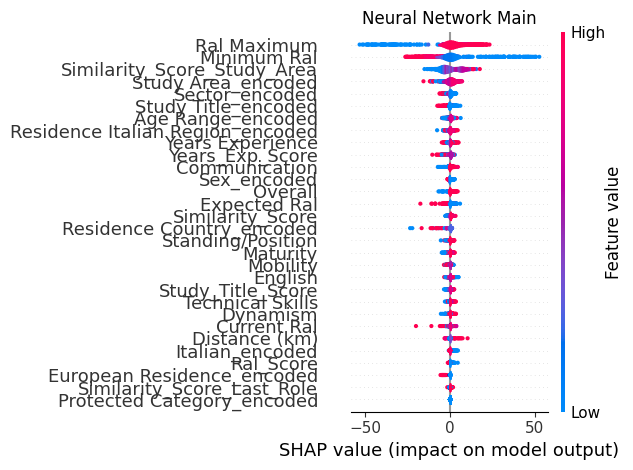

In [109]:
summaryPlot(main_model, X_test.iloc[:1000], tot_columns, plot_type='violin', plot_name=f'Neural Network Main')